In [45]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import model_selection
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.stats import pearsonr as psr
from scipy.sparse import csr_matrix
import seaborn as sns; sns.set()  # for plot styling

# Data Setup and Analysis

In [80]:
# Reading rating file
ratings = pd.read_csv('Data/BX-Book-Ratings.csv', sep=';', encoding='latin-1')

# Reading users file
users = pd.read_csv('Data/BX-Users.csv', sep=';', encoding='latin-1')

# Reading books file
books = pd.read_csv('Data/BX-Books.csv',  sep=';', encoding='latin-1')

In [3]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
n_users = users['User-ID'].size
n_ratings = ratings['User-ID'].size
print('Number of users:', n_users)
print('Number of ratings', n_ratings)

Number of users: 278858
Number of ratings 1149780


## other way

In [81]:
user_count = pd.DataFrame(ratings.groupby(['User-ID']).count()['ISBN'])
user_count.columns = ["rating_count"]
user_count.head()

,rating_count
User-ID,
2,1
7,1
8,18
9,3
10,2


In [82]:
max_rating_count = np.max(user_count)
print("Maximum rating is:", max_rating_count[0])

Maximum rating is: 13602


In [97]:
users['rating_count']=user_count
users['rating_count'] = users['rating_count'].fillna(0).astype(int)

In [98]:
users.head()

,User-ID,Location,Age,rating_count
0,1,"nyc, new york, usa",NaN,0
1,2,"stockton, california, usa",18.0,0
2,3,"moscow, yukon territory, russia",NaN,1
3,4,"porto, v.n.gaia, portugal",17.0,0
4,5,"farnborough, hants, united kingdom",NaN,0


In [99]:
less_than_5 = users[users['rating_count']<5]

Text(0, 0.5, 'Distribution label count')

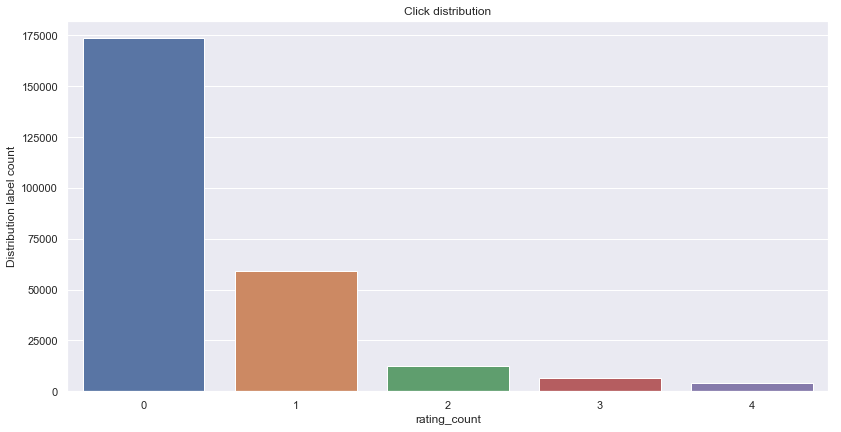

In [100]:
plt.figure(figsize = (30,15))
ax1 = plt.subplot2grid((2,2), (0,0))
sns.countplot(x = 'rating_count',  data = less_than_5, ax = ax1)
ax1.set_title('Click distribution')
ax1.set_ylabel('Distribution label count')

13602


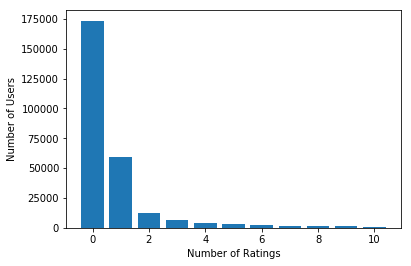

In [4]:
# Data repartition (number of ratings per user)

user_count = {}
ratings_count = np.zeros(11)
maximum = 0
ID = -1

for i in range(0,n_users):
    user_count[i+1] = 0

for element in ratings.values:
    user, ISBN, rating = element
    user_count[user]+=1
    ratings_count[rating]+=1
    if user_count[user]>maximum:
        maximum = user_count[user]
        ID = user

print(maximum)
# Plotting 
val = np.zeros(maximum+1)
for i in range(len(val)):
    val[i]=i
num = np.zeros(maximum+1)
for i in user_count:
    num[user_count[i]]+=1
    
plt.bar(val[0:11],num[0:11])
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

In [30]:
sum(num)

278858.0

In [32]:
ratings.

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [15]:
np.max(ratings.groupby(['User-ID']).count()['ISBN'].values)

13602

In [16]:
sum(ratings.groupby(['Book-Rating']).count()['ISBN'])

1149780

In [5]:
# Get the number of users with n ratings or more
n = 5

cc = 0
k = 0
for i in num:
    if k>=n:
        cc += int(i)
    k+=1
print('Number of users with 5 ratings or more:',cc)

Number of users with 5 ratings or more: 22816


Most users only have 0 or 1 rating

=> We chose to train and evaluate the model on users with more than 5 ratings

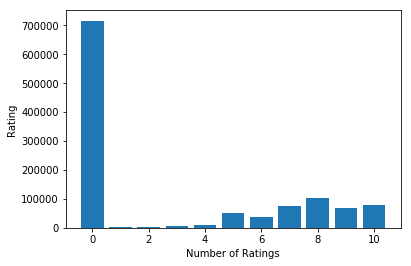

In [6]:
# rating repartition

plt.bar(range(11),ratings_count)
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

0 ratings dominant and seem unrealistic

=> delete all the 0 ratings

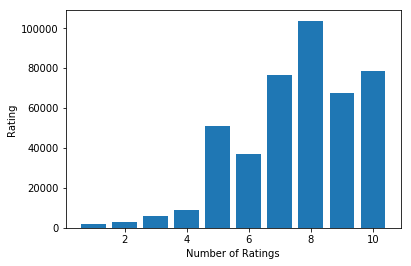

In [7]:
# rating repartition

plt.bar(range(1,11),ratings_count[1:])
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

# Data Clearing

In [8]:
# Parameters
min_val = 5
min_ratings = 5

In [9]:
# Initialisation
cleaned_data = ratings.copy()
cleaned_users = users.copy()
cleaned_books = books.copy()

In [10]:
# Delete all 0 ratings
cleaned_data = cleaned_data[ cleaned_data['Book-Rating']>0]

# Delete books with less than min_ratings ratings
ratings_per_book =  cleaned_data['ISBN'].value_counts()
cleaned_data = cleaned_data[cleaned_data['ISBN'].isin(ratings_per_book.index[ratings_per_book.values >= min_val])]

In [11]:
# Number of ratings per user
ratings_per_user = cleaned_data['User-ID'].value_counts()
ratings_per_book = cleaned_data['ISBN'].value_counts()

In [12]:
# Select data from users with more than min_val ratings
cleaned_data = cleaned_data[cleaned_data['User-ID'].isin(ratings_per_user.index[ratings_per_user.values >= min_val])]

# Get the selected users
cleaned_users = sorted(cleaned_data['User-ID'].unique())

In [13]:
# Create the pivot table
table = pd.pivot_table(cleaned_data, values='Book-Rating', index='User-ID', columns='ISBN')

In [14]:
# Create train and test set
X_train, X_test = model_selection.train_test_split(table, test_size=0.25, random_state=42)

In [15]:
# Get the users average rating
means = {}
idx = table.index
for i in idx:
    means[i] = np.nanmean(table[table.index==i])

In [16]:
# Get the books average rating
ISBN_means = {}
ISBN_list = table.columns
for i in ISBN_list:
    ISBN_means[i] = np.nanmean(table[i].values)

# User - User

In [220]:
class User_User_prediction():
    def __init__(self, books, table, means):
        self.books = books
        self.means = means
        self.table = table

        
    def predict(self, user, k=-1):
        prediction = np.zeros(len(self.table.columns.values))
        prediction.fill(means[user])
        mask = np.isnan(self.table[table.index == user])
        sel = 0
        sim_dic = {}
        user_t = self.table[self.table.index == user].values[0]

        for user2 in cleaned_users:
            user2_t = self.table[self.table.index == user2].values[0]
            sim_dic[user2] = sim(user_t, user2_t)

        user_sel, score_sel = zip(*find_closest(sim_dic,k))

        for i in range(len(user_sel)):
            prediction += score_sel[i] * (self.table[self.table.index == user_sel[i]].values[0] - self.means[user_sel[i]])
            sel += abs(score_sel[i])
        prediction = prediction / sel
        return prediction*mask

        
    def pearsons(self, user1, user2):
        return psr(user1, user2)[0]

    
    def find_closest(self, dic, k=-1):
        sorted_dic = sorted(dic.items(), key = lambda sd:(sd[1], sd[0]), reverse = True)
        if k==-1:
            return sorted_dic
        else:
            return sorted_dic[:k]
        
        
    def get_max(self, prediction):
        max_val = np.argmax(prediction)
        book = self.books[self.books['ISBN'] == prediction[max_val]]
        
    
    def process(self, user, k=-1, n=5):
        prediction = self.predict(user, k)
        idx = np.argpartition(prediction, -n)[-n:]
        idx = idx[np.argsort(prediction[idx])]
        best = pred[ind]
        names = []
        for isbn in best:
            names.append(books[books['ISBN'] == isbn][['Book-Title', 'Book-Author']].values[0])
        return names

# Item - Item

# Matrix Factorisation

In [ ]:
class SVD_prediction():
    
    def __init__(self, books, table):
        self.books = books
        self.table = table
        
        
    def perform(self, k):
        values = svds(self.table, k=k)

In [57]:
sparse = csr_matrix(table.values)

In [58]:
sparse

<7983x14451 sparse matrix of type '<class 'numpy.float64'>'
	with 115362333 stored elements in Compressed Sparse Row format>

In [ ]:
for i in :
    for j in:
        (x[i][j] - u[i]*a[j])**2 + gamma * (np.linalg.norm(u[i]) + np.linalg.norm(u[j]))

minui
,aj
X
Present(i,j)
(xij − ui
t
.aj)
2 + λ(
X
i
||ui
||2 +
X
j
||aj
||2
)

In [152]:
table

ISBN,0000000000,0002005018,0002251760,0002259001,0002259834,0002558122,0003300277,0006172768,0006374921,0006385427,...,9724127001,9726101794,9726106141,9726116902,9727591965,9727722458,9770390107900,9771129085131,9871138148,9895550138
User-ID,,,,,,,,,,,,,,,,,,,,,
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
sparse2 = table.to_sparse()

In [155]:
table_test = table.copy()
table_test = table_test.replace(np.NaN, 0.)
#table_test = table_test.astype(int)

sparse = csr_matrix(table_test.values)
sparse

<7983x14451 sparse matrix of type '<class 'numpy.float64'>'
	with 138282 stored elements in Compressed Sparse Row format>

In [160]:
u, m, a = svds(sparse, k = 36)

In [139]:
pos = zip(*sparse.nonzero())
error = 0
gamma = 0.01
for p in pos:
    i,j = p
    val = table.values[i][j]
    estimation = u[i].dot(a[j])
    error += (val-estimation)**2 + gamma*(np.linalg.norm(u[i]**2 + np.linalg.norm(a[j])**2)  

8.0
8.0
7.0
10.0
3.0
9.0
9.0
8.0
8.0
9.0
10.0
10.0
8.0
9.0
7.0
8.0
8.0
7.0
10.0
7.0
9.0
9.0
7.0
10.0
6.0
7.0
9.0
7.0
9.0
6.0
6.0
8.0
5.0
5.0
7.0
8.0
9.0
8.0
9.0
8.0
6.0
6.0
9.0
7.0
7.0
5.0
9.0
6.0
5.0
8.0
9.0
9.0
8.0
10.0
8.0
10.0
9.0
8.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
6.0
7.0
9.0
8.0
8.0
9.0
9.0
8.0
7.0
8.0
8.0
9.0
9.0
8.0
3.0
6.0
7.0
10.0
10.0
10.0
5.0
7.0
8.0
8.0
10.0
3.0
10.0
5.0
10.0
8.0
10.0
10.0
10.0
8.0
10.0
10.0
9.0
7.0
8.0
7.0
8.0
8.0
9.0
9.0
8.0
7.0
10.0
9.0
8.0
9.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
9.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
8.0
9.0
10.0
10.0
9.0
10.0
10.0
9.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
9.0
9.0
10.0
10.0
8.0
9.0
9.0
10.0
9.0
9.0
10.0
10.0
8.0
8.0
7.0
9.0
10.0
10.0
9.0
7.0
10.0
9.0
9.0
10.0
10.0
8.0
9.0
8.0
8.0
9.0
8.0
9.0
8.0
9.0
7.0
8.0
8.0
8.0
8.0
2.0
8.0
8.0
9.0
10.0
8.0
8.0
7.0
7.0
6.0
8.0
7.0
4.0
7.0
7.0
8.0
6.0
6.0
9.0
10.0
10.0
3.0
7.0
10.0
9.0
4.0
7.0
9.0
9.0
8.0
9.0
10.0
7.0
9.0
10.0
10.0
4.0
9.0
7.0
8.0
10.0
9.0
8.0
8.0
8.0
8.0
10.0
8.0
10.0
5.0
2

8.0
9.0
8.0
8.0
8.0
7.0
6.0
9.0
8.0
8.0
6.0
6.0
6.0
6.0
9.0
8.0
7.0
9.0
8.0
7.0
7.0
9.0
8.0
8.0
8.0
8.0
7.0
9.0
7.0
8.0
7.0
7.0
8.0
8.0
8.0
6.0
8.0
9.0
9.0
7.0
10.0
9.0
8.0
8.0
8.0
7.0
9.0
7.0
7.0
7.0
9.0
7.0
7.0
8.0
7.0
8.0
8.0
7.0
8.0
7.0
8.0
7.0
7.0
8.0
8.0
8.0
9.0
9.0
8.0
8.0
7.0
8.0
6.0
8.0
8.0
7.0
9.0
10.0
10.0
8.0
8.0
9.0
8.0
8.0
9.0
10.0
6.0
9.0
9.0
8.0
6.0
7.0
7.0
10.0
8.0
9.0
8.0
9.0
10.0
7.0
10.0
10.0
7.0
7.0
8.0
7.0
8.0
7.0
8.0
8.0
9.0
8.0
7.0
8.0
8.0
6.0
9.0
7.0
10.0
8.0
8.0
7.0
10.0
9.0
8.0
7.0
8.0
9.0
8.0
9.0
6.0
8.0
7.0
6.0
7.0
8.0
8.0
8.0
7.0
9.0
7.0
7.0
8.0
6.0
6.0
6.0
5.0
6.0
7.0
6.0
8.0
8.0
8.0
9.0
3.0
7.0
9.0
9.0
8.0
6.0
6.0
8.0
9.0
10.0
6.0
7.0
7.0
7.0
7.0
9.0
8.0
5.0
8.0
8.0
10.0
9.0
8.0
7.0
7.0
8.0
6.0
8.0
6.0
8.0
3.0
8.0
9.0
8.0
7.0
10.0
10.0
10.0
10.0
9.0
8.0
10.0
9.0
9.0
10.0
8.0
10.0
7.0
9.0
9.0
5.0
5.0
8.0
9.0
9.0
9.0
9.0
10.0
10.0
9.0
10.0
8.0
8.0
8.0
8.0
9.0
7.0
7.0
5.0
7.0
5.0
6.0
7.0
9.0
8.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
4.0

10.0
5.0
8.0
5.0
8.0
9.0
7.0
8.0
7.0
5.0
6.0
10.0
5.0
8.0
6.0
10.0
5.0
6.0
8.0
6.0
7.0
9.0
9.0
7.0
8.0
7.0
8.0
9.0
10.0
9.0
3.0
8.0
9.0
6.0
8.0
10.0
6.0
9.0
7.0
10.0
7.0
8.0
9.0
10.0
9.0
8.0
8.0
9.0
8.0
8.0
7.0
9.0
1.0
8.0
10.0
10.0
10.0
10.0
7.0
5.0
10.0
8.0
8.0
9.0
3.0
10.0
5.0
10.0
10.0
3.0
10.0
8.0
9.0
7.0
6.0
8.0
9.0
9.0
5.0
9.0
7.0
7.0
10.0
8.0
7.0
9.0
4.0
8.0
2.0
8.0
10.0
7.0
6.0
7.0
9.0
7.0
7.0
8.0
10.0
8.0
7.0
8.0
8.0
8.0
6.0
6.0
6.0
8.0
5.0
9.0
8.0
6.0
7.0
6.0
2.0
8.0
9.0
3.0
9.0
8.0
7.0
10.0
9.0
8.0
9.0
7.0
8.0
7.0
9.0
5.0
8.0
9.0
7.0
6.0
5.0
9.0
10.0
8.0
7.0
10.0
6.0
8.0
4.0
7.0
8.0
6.0
6.0
9.0
10.0
6.0
7.0
10.0
8.0
5.0
7.0
5.0
8.0
7.0
10.0
8.0
10.0
10.0
8.0
7.0
9.0
10.0
9.0
8.0
8.0
9.0
6.0
8.0
3.0
7.0
8.0
9.0
5.0
7.0
7.0
3.0
10.0
10.0
9.0
8.0
7.0
8.0
10.0
4.0
9.0
5.0
8.0
10.0
9.0
10.0
8.0
7.0
8.0
7.0
9.0
5.0
9.0
9.0
10.0
8.0
10.0
5.0
8.0
5.0
8.0
10.0
10.0
7.0
8.0
8.0
8.0
8.0
4.0
5.0
10.0
10.0
6.0
10.0
8.0
6.0
5.0
10.0
7.0
10.0
5.0
8.0
9.0
9.0
6.0
5.0
7.0
4.0
9.0
8.0
7.0
8.

10.0
9.0
8.0
5.0
7.0
5.0
5.0
7.0
7.0
10.0
6.0
10.0
7.0
8.0
10.0
7.0
10.0
8.0
7.0
5.0
8.0
7.0
8.0
5.0
8.0
8.0
8.0
6.0
8.0
7.0
8.0
6.0
8.0
8.0
8.0
8.0
5.0
6.0
10.0
10.0
7.0
6.0
10.0
6.0
7.0
8.0
5.0
8.0
10.0
5.0
9.0
8.0
1.0
6.0
7.0
6.0
10.0
10.0
5.0
8.0
8.0
6.0
7.0
7.0
6.0
8.0
8.0
4.0
10.0
8.0
5.0
7.0
5.0
7.0
8.0
8.0
5.0
8.0
7.0
10.0
3.0
10.0
9.0
9.0
8.0
3.0
2.0
6.0
10.0
8.0
10.0
8.0
10.0
8.0
8.0
8.0
8.0
8.0
9.0
9.0
8.0
8.0
7.0
4.0
6.0
5.0
10.0
5.0
7.0
8.0
10.0
10.0
10.0
7.0
6.0
10.0
8.0
9.0
4.0
10.0
10.0
8.0
10.0
5.0
6.0
10.0
8.0
7.0
9.0
10.0
9.0
7.0
10.0
10.0
3.0
9.0
8.0
7.0
10.0
7.0
6.0
8.0
9.0
10.0
8.0
6.0
4.0
8.0
5.0
10.0
9.0
7.0
8.0
10.0
9.0
7.0
10.0
7.0
6.0
7.0
7.0
7.0
10.0
3.0
8.0
8.0
7.0
8.0
8.0
10.0
10.0
10.0
9.0
8.0
10.0
3.0
5.0
5.0
9.0
8.0
8.0
8.0
7.0
1.0
6.0
8.0
3.0
7.0
8.0
4.0
8.0
7.0
6.0
8.0
10.0
9.0
10.0
7.0
7.0
8.0
9.0
10.0
5.0
8.0
8.0
5.0
7.0
9.0
9.0
7.0
5.0
10.0
9.0
6.0
6.0
6.0
9.0
8.0
8.0
9.0
10.0
9.0
2.0
6.0
8.0
7.0
7.0
7.0
8.0
7.0
9.0
8.0
8.0
8.0
10.0
8.0
10.0
10.0
7

8.0
10.0
8.0
8.0
2.0
6.0
8.0
9.0
8.0
9.0
7.0
6.0
6.0
7.0
3.0
4.0
10.0
7.0
9.0
6.0
8.0
6.0
8.0
10.0
7.0
9.0
9.0
9.0
7.0
8.0
8.0
6.0
9.0
7.0
6.0
8.0
8.0
8.0
8.0
9.0
8.0
9.0
5.0
8.0
8.0
6.0
5.0
9.0
9.0
7.0
7.0
5.0
5.0
9.0
10.0
8.0
7.0
9.0
8.0
9.0
7.0
8.0
7.0
7.0
7.0
7.0
8.0
7.0
7.0
9.0
8.0
10.0
8.0
8.0
8.0
8.0
9.0
6.0
7.0
7.0
7.0
5.0
9.0
8.0
7.0
9.0
10.0
9.0
6.0
5.0
5.0
5.0
7.0
9.0
4.0
7.0
7.0
7.0
8.0
7.0
8.0
7.0
8.0
7.0
7.0
8.0
8.0
10.0
9.0
7.0
9.0
4.0
8.0
9.0
8.0
7.0
8.0
7.0
8.0
7.0
7.0
10.0
8.0
8.0
8.0
8.0
7.0
9.0
10.0
6.0
6.0
8.0
8.0
8.0
9.0
7.0
9.0
8.0
7.0
7.0
7.0
7.0
8.0
4.0
6.0
6.0
6.0
10.0
7.0
8.0
6.0
8.0
10.0
9.0
9.0
5.0
8.0
8.0
5.0
10.0
9.0
10.0
7.0
9.0
9.0
5.0
9.0
3.0
7.0
8.0
8.0
7.0
8.0
5.0
10.0
5.0
7.0
7.0
8.0
8.0
2.0
5.0
8.0
8.0
7.0
7.0
7.0
8.0
8.0
8.0
7.0
10.0
5.0
5.0
9.0
8.0
7.0
10.0
9.0
9.0
8.0
10.0
9.0
8.0
10.0
10.0
7.0
4.0
9.0
9.0
9.0
10.0
10.0
10.0
4.0
10.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
10.0
9.0
10.0
5.0
9.0
6.0
6.0
9.0
9.0
9.0
8

5.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
8.0
9.0
7.0
10.0
7.0
7.0
7.0
8.0
9.0
5.0
10.0
7.0
10.0
10.0
9.0
10.0
8.0
10.0
10.0
10.0
6.0
4.0
9.0
10.0
10.0
8.0
10.0
10.0
10.0
9.0
10.0
8.0
8.0
10.0
10.0
5.0
9.0
8.0
9.0
8.0
8.0
9.0
9.0
9.0
8.0
8.0
3.0
9.0
9.0
7.0
7.0
7.0
6.0
6.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
7.0
5.0
5.0
8.0
6.0
5.0
6.0
6.0
6.0
6.0
7.0
7.0
6.0
3.0
6.0
8.0
8.0
8.0
9.0
5.0
8.0
10.0
10.0
8.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
7.0
7.0
8.0
8.0
5.0
10.0
10.0
9.0
8.0
8.0
9.0
7.0
4.0
9.0
6.0
8.0
9.0
7.0
9.0
8.0
8.0
8.0
3.0
6.0
8.0
9.0
8.0
8.0
9.0
6.0
8.0
6.0
7.0
8.0
7.0
8.0
9.0
10.0
10.0
4.0
10.0
9.0
10.0
8.0
6.0
5.0
5.0
4.0
4.0
8.0
6.0
8.0
6.0
5.0
6.0
7.0
5.0
6.0
8.0
6.0
7.0
3.0
9.0
7.0
8.0
9.0
7.0
7.0
9.0
8.0
7.0
7.0
9.0
5.0
5.0
9.0
2.0
8.0
6.0
9.0
8.0
8.0
7.0
9.0
6.0
2.0
8.0
9.0
9.0
8.0
9.0
5.0
3.0
3.0
9.0
9.0
9.0
9.0
9.0
5.0
9.0
7.0
5.0
8.0
8.0
8.0
9.0
8.0
8.0
5.0
10.0
8.0
10.0
10.0
10.0
10.0
7.0
9.0
10.0
10.0
8.0
10.0
9.0
5.0
9.0
8.0
10.0
9.0
8.0
9.0
8.0
9.0
9.0
8.0
9.0
9.0
8.

8.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
8.0
10.0
10.0
6.0
8.0
9.0
10.0
9.0
10.0
10.0
9.0
7.0
7.0
10.0
9.0
8.0
7.0
6.0
8.0
5.0
8.0
10.0
8.0
7.0
9.0
7.0
4.0
8.0
9.0
8.0
7.0
8.0
10.0
7.0
10.0
8.0
9.0
10.0
8.0
9.0
9.0
10.0
9.0
8.0
8.0
9.0
8.0
6.0
7.0
7.0
10.0
10.0
9.0
10.0
7.0
10.0
9.0
7.0
8.0
7.0
3.0
5.0
6.0
8.0
9.0
6.0
8.0
8.0
10.0
8.0
7.0
10.0
9.0
8.0
7.0
7.0
8.0
7.0
7.0
10.0
10.0
10.0
10.0
5.0
10.0
6.0
8.0
9.0
9.0
9.0
7.0
9.0
10.0
9.0
7.0
10.0
10.0
9.0
10.0
10.0
8.0
8.0
10.0
10.0
10.0
7.0
8.0
10.0
9.0
10.0
10.0
9.0
10.0
10.0
9.0
9.0
5.0
5.0
5.0
7.0
8.0
8.0
8.0
7.0
7.0
6.0
5.0
6.0
10.0
8.0
10.0
10.0
10.0
5.0
10.0
10.0
7.0
8.0
9.0
10.0
7.0
8.0
9.0
8.0
8.0
9.0
7.0
6.0
5.0
5.0
4.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
8.0
10.0
7.0
9.0
10.0
9.0
8.0
5.0
8.0
4.0
6.0
8.0
8.0
8.0
8.0
8.0
10.0
8.0
10.0
8.0
6.0
5.0
8.0
10.0
8.0
10.0
5.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
9.0
8.0
10.0
10.0
4.0
10.0
10.0
5.0
5.0
9.0

6.0
7.0
7.0
7.0
7.0
9.0
8.0
8.0
9.0
7.0
7.0
9.0
9.0
8.0
8.0
5.0
8.0
8.0
8.0
5.0
5.0
8.0
5.0
7.0
8.0
8.0
9.0
9.0
5.0
5.0
7.0
5.0
8.0
6.0
8.0
10.0
10.0
10.0
10.0
7.0
6.0
7.0
7.0
9.0
7.0
5.0
6.0
10.0
7.0
8.0
10.0
9.0
9.0
8.0
10.0
9.0
9.0
5.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
7.0
9.0
9.0
10.0
7.0
7.0
10.0
9.0
10.0
10.0
7.0
8.0
5.0
5.0
8.0
7.0
5.0
6.0
8.0
9.0
5.0
9.0
9.0
8.0
10.0
10.0
10.0
7.0
9.0
10.0
10.0
8.0
10.0
8.0
10.0
10.0
10.0
6.0
6.0
10.0
10.0
8.0
9.0
9.0
7.0
7.0
9.0
7.0
9.0
8.0
7.0
7.0
7.0
6.0
7.0
9.0
4.0
7.0
7.0
10.0
7.0
6.0
7.0
7.0
8.0
5.0
8.0
5.0
9.0
6.0
9.0
8.0
10.0
7.0
8.0
5.0
6.0
6.0
8.0
7.0
8.0
8.0
8.0
7.0
8.0
8.0
7.0
8.0
6.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
6.0
7.0
8.0
7.0
5.0
5.0
5.0
8.0
10.0
10.0
10.0
10.0
9.0
7.0
7.0
9.0
9.0
10.0
6.0
5.0
9.0
10.0
10.0
10.0
9.0
10.0
7.0
8.0
8.0
9.0
7.0
8.0
10.0
8.0
9.0
6.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
8.0
7.0
8.0
8.0
8.0
5.0
5.0


10.0
10.0
9.0
10.0
7.0
10.0
9.0
9.0
7.0
8.0
7.0
5.0
10.0
8.0
10.0
8.0
7.0
9.0
8.0
10.0
8.0
8.0
8.0
9.0
10.0
8.0
7.0
6.0
7.0
5.0
6.0
7.0
7.0
5.0
6.0
7.0
6.0
6.0
6.0
8.0
9.0
6.0
9.0
10.0
7.0
7.0
7.0
8.0
10.0
5.0
5.0
8.0
8.0
10.0
10.0
4.0
10.0
5.0
10.0
5.0
9.0
6.0
8.0
9.0
9.0
10.0
10.0
9.0
10.0
5.0
5.0
6.0
7.0
5.0
5.0
5.0
10.0
10.0
10.0
10.0
10.0
1.0
7.0
8.0
8.0
6.0
6.0
8.0
8.0
9.0
7.0
8.0
9.0
10.0
9.0
8.0
8.0
8.0
8.0
5.0
9.0
8.0
9.0
6.0
6.0
7.0
7.0
7.0
5.0
8.0
8.0
6.0
8.0
9.0
8.0
7.0
10.0
8.0
9.0
7.0
6.0
6.0
8.0
8.0
8.0
8.0
6.0
6.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
7.0
8.0
9.0
6.0
9.0
7.0
5.0
7.0
5.0
9.0
8.0
7.0
8.0
7.0
7.0
8.0
7.0
7.0
8.0
9.0
9.0
7.0
6.0
8.0
7.0
9.0
7.0
10.0
10.0
9.0
8.0
10.0
8.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
7.0
7.0
8.0
5.0
3.0
6.0
4.0
7.0
10.0
5.0
3.0
8.0
8.0
8.0
8.0
9.0
8.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
4.0
10.0
10.0
10.0
9.0
9.0
9.0
9.0
8.0
5.0
9.0
8.0
9.0
10.0
10.0
9.0
10.0
10.0
8.0
9.0
9.0
9.0
10.0
10.0
9.0
8.0
10.0
9.0
8.0
9.0
9.0
8.0
9.0
9.0
8.0
9.0
9.0
8.0


8.0
7.0
7.0
6.0
6.0
8.0
8.0
8.0
8.0
5.0
5.0
5.0
7.0
7.0
10.0
10.0
7.0
8.0
9.0
9.0
6.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
5.0
5.0
6.0
4.0
6.0
9.0
10.0
8.0
8.0
9.0
8.0
8.0
10.0
8.0
8.0
10.0
7.0
8.0
9.0
8.0
10.0
8.0
10.0
10.0
9.0
10.0
5.0
5.0
6.0
7.0
9.0
8.0
8.0
8.0
8.0
6.0
4.0
8.0
10.0
8.0
9.0
9.0
8.0
9.0
9.0
7.0
9.0
8.0
10.0
10.0
7.0
7.0
8.0
8.0
7.0
10.0
6.0
6.0
10.0
6.0
7.0
9.0
10.0
8.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
6.0
5.0
10.0
10.0
10.0
9.0
10.0
9.0
7.0
7.0
10.0
9.0
8.0
9.0
9.0
8.0
7.0
9.0
8.0
8.0
8.0
8.0
10.0
8.0
10.0
10.0
3.0
7.0
7.0
7.0
8.0
7.0
7.0
8.0
9.0
9.0
8.0
10.0
7.0
7.0
5.0
8.0
9.0
7.0
6.0
7.0
10.0
9.0
9.0
10.0
9.0
8.0
10.0
6.0
9.0
9.0
9.0
8.0
10.0
8.0
7.0
5.0
7.0
8.0
8.0
7.0
8.0
5.0
6.0
5.0
7.0
8.0
10.0
6.0
7.0
7.0
7.0
8.0
8.0
9.0
9.0
7.0
8.0
8.0
9.0
8.0
8.0
9.0
9.0
9.0
9.0
7.0
8.0
6.0
10.0
6.0
9.0
9.0
8.0
9.0
8.0
10.0
7.0
9.0
6.0
8.0
7.0
9.0
9.0
8.0
7.0
8.0
9.0
9.0
7.0
7.0
9.0
7.0
5.0
5.0
4.0
5.0
7.0
5.0
6.0
5.0
8.0
3.0
9.0
7.0
6.0
6.0
6.0
9

8.0
10.0
1.0
9.0
9.0
8.0
8.0
8.0
8.0
8.0
10.0
10.0
8.0
10.0
9.0
8.0
9.0
7.0
8.0
10.0
10.0
10.0
10.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
7.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
7.0
7.0
7.0
10.0
5.0
10.0
7.0
7.0
7.0
7.0
7.0
8.0
10.0
8.0
7.0
7.0
7.0
7.0
7.0
10.0
7.0
5.0
10.0
10.0
7.0
8.0
10.0
10.0
8.0
7.0
7.0
10.0
10.0
10.0
5.0
8.0
7.0
7.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
7.0
8.0
8.0
9.0
5.0
7.0
6.0
8.0
6.0
10.0
10.0
6.0
10.0
8.0
9.0
10.0
10.0
7.0
7.0
8.0
7.0
7.0
9.0
7.0
8.0
8.0
7.0
9.0
9.0
9.0
8.0
8.0
10.0
8.0
7.0
8.0
8.0
10.0
7.0
5.0
9.0
7.0
4.0
7.0
8.0
3.0
3.0
6.0
10.0
8.0
8.0
9.0
7.0
8.0
7.0
6.0
4.0
9.0
9.0
9.0
9.0
8.0
9.0
8.0
6.0
7.0
5.0
6.0
8.0
10.0
5.0
5.0
5.0
10.0
7.0
10.0
10.0
6.0
8.0
6.0
4.0
9.0
7.0
10.0
6.0
7.0
9.0
7.0
7.0
9.0
4.0
5.0
6.0
8.0
8.0
8.0
8.0
5.0
6.0
7.0
7.0
8.0
6.0
7.0
6.0
7.0
7.0
3.0
8.0
6.0
8.0
9.0
3.0
5.0
5.0
10.0
9.0
9.0
4.0
8.0
3.0
7.0
7.0
7.0
3.0
9.0
7.0
8.0
7.0
9.0
7

8.0
9.0
10.0
5.0
5.0
6.0
10.0
8.0
7.0
10.0
10.0
10.0
8.0
6.0
8.0
8.0
7.0
10.0
10.0
10.0
5.0
8.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
8.0
7.0
4.0
7.0
6.0
5.0
8.0
10.0
10.0
10.0
7.0
7.0
8.0
9.0
7.0
8.0
7.0
6.0
10.0
10.0
8.0
5.0
8.0
9.0
6.0
6.0
5.0
10.0
8.0
5.0
5.0
7.0
10.0
10.0
9.0
6.0
7.0
5.0
9.0
10.0
10.0
10.0
9.0
8.0
9.0
9.0
7.0
10.0
8.0
7.0
7.0
8.0
7.0
8.0
6.0
7.0
9.0
7.0
9.0
5.0
8.0
7.0
9.0
9.0
7.0
5.0
6.0
8.0
7.0
7.0
9.0
7.0
8.0
8.0
8.0
7.0
6.0
7.0
6.0
5.0
7.0
6.0
6.0
7.0
7.0
8.0
7.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
1.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
10.0
9.0
10.0
9.0
10.0
10.0
10.0
5.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
7.0
10.0
8.0
10.0
10.0
10.0
5.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
8.0
5.0
10.0
10.0
10.0
10.0
5.0
10.0
10.0
6.0
9.0
7.0
8.0
5.0
9.0
10.0
10.0
10.0
10.0
10.0
7.0
6.0
8.0
6.0
7.0
9.0
7.0
8.0
9.0
8.0
8.0
8.0
7.0
8.0
8.0
7.0
9.0
7.0
9.0
8.0
7.0
8.0
9.0
8.0
8.0
8.0
8.0
8.0
7.0
7.0
8.0
6.0
6.0
7.0
8.0
8.0
8.0
8.0

3.0
5.0
7.0
5.0
5.0
8.0
8.0
7.0
6.0
7.0
3.0
8.0
10.0
6.0
6.0
9.0
10.0
10.0
9.0
7.0
10.0
5.0
10.0
5.0
3.0
8.0
4.0
8.0
8.0
5.0
5.0
6.0
6.0
8.0
5.0
8.0
9.0
9.0
9.0
9.0
5.0
4.0
3.0
7.0
5.0
8.0
7.0
7.0
5.0
8.0
7.0
10.0
6.0
7.0
8.0
5.0
5.0
7.0
6.0
6.0
6.0
7.0
7.0
6.0
5.0
6.0
10.0
5.0
9.0
9.0
6.0
8.0
9.0
8.0
6.0
8.0
6.0
7.0
8.0
7.0
8.0
8.0
8.0
6.0
9.0
5.0
8.0
8.0
9.0
8.0
9.0
9.0
6.0
9.0
10.0
9.0
6.0
9.0
10.0
9.0
9.0
9.0
9.0
8.0
6.0
9.0
7.0
8.0
5.0
6.0
7.0
4.0
9.0
8.0
6.0
8.0
8.0
10.0
9.0
8.0
5.0
9.0
8.0
8.0
7.0
5.0
7.0
8.0
9.0
8.0
7.0
7.0
7.0
8.0
8.0
8.0
6.0
10.0
9.0
9.0
8.0
7.0
10.0
9.0
9.0
6.0
9.0
7.0
10.0
8.0
9.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
6.0
6.0
8.0
8.0
9.0
8.0
6.0
9.0
9.0
10.0
9.0
10.0
9.0
10.0
8.0
7.0
7.0
6.0
3.0
8.0
7.0
7.0
7.0
4.0
8.0
9.0
8.0
9.0
8.0
10.0
10.0
9.0
8.0
5.0
8.0
8.0
10.0
10.0
8.0
9.0
8.0
7.0
8.0
8.0
7.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
8.0
9.0
7.0
6.0
7.0
6.0
6.0
6.0
6.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
9.0
7.0
9.0
6.0
6.0
7.0
9.0
9.0
8.0
8.0

7.0
8.0
7.0
7.0
7.0
5.0
9.0
6.0
7.0
7.0
7.0
7.0
5.0
5.0
5.0
6.0
10.0
10.0
8.0
9.0
3.0
10.0
4.0
10.0
10.0
9.0
9.0
10.0
8.0
7.0
5.0
6.0
5.0
6.0
6.0
5.0
7.0
5.0
5.0
5.0
5.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
9.0
7.0
5.0
9.0
5.0
5.0
8.0
5.0
9.0
5.0
7.0
9.0
10.0
10.0
9.0
7.0
7.0
9.0
8.0
8.0
10.0
8.0
7.0
10.0
6.0
10.0
10.0
8.0
10.0
10.0
8.0
5.0
7.0
10.0
10.0
8.0
9.0
10.0
10.0
8.0
9.0
5.0
8.0
8.0
8.0
9.0
10.0
9.0
10.0
10.0
9.0
7.0
10.0
7.0
8.0
9.0
8.0
9.0
7.0
7.0
7.0
5.0
4.0
6.0
8.0
7.0
5.0
8.0
6.0
6.0
9.0
9.0
8.0
7.0
9.0
3.0
10.0
9.0
10.0
9.0
7.0
8.0
10.0
10.0
3.0
10.0
10.0
4.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
7.0
7.0
9.0
9.0
8.0
7.0
5.0
6.0
8.0
10.0
10.0
10.0
9.0
10.0
10.0
9.0
10.0
7.0
8.0
10.0
10.0
10.0
5.0
8.0
8.0
8.0
7.0
9.0
10.0
10.0
10.0
10.0
10.0
9.0
7.0
10.0
9.0
9.0
9.0
10.0
10.0
9.0
7.0
8.0
8.0
8.0
7.0
10.0
8.0
10.0
7.0
6.0
10.0
7.0
5.0
8.0
5.0
7.0
9.0
7.0
2.0
8.0
7.0
5.0
3.0
6.0
10.0
3.0
7.0
7.0
5.0
6.0
7.0
6.0
10.

10.0
8.0
10.0
8.0
9.0
10.0
6.0
7.0
8.0
9.0
10.0
10.0
8.0
9.0
7.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
10.0
10.0
7.0
10.0
6.0
7.0
10.0
7.0
10.0
10.0
7.0
6.0
10.0
6.0
4.0
9.0
8.0
5.0
9.0
10.0
5.0
10.0
7.0
7.0
9.0
7.0
7.0
10.0
10.0
10.0
10.0
7.0
7.0
10.0
10.0
4.0
8.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
9.0
5.0
5.0
5.0
8.0
9.0
9.0
6.0
9.0
10.0
5.0
7.0
9.0
4.0
9.0
8.0
7.0
9.0
7.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
10.0
10.0
10.0
5.0
4.0
10.0
5.0
10.0
10.0
7.0
7.0
10.0
9.0
9.0
7.0
10.0
10.0
5.0
9.0
10.0
9.0
10.0
10.0
10.0
5.0
10.0
3.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
8.0
10.0
9.0
8.0
5.0
8.0
7.0
4.0
5.0
8.0
10.0
5.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
10.0
9.0
9.0
10.0
5.0
9.0
8.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
10.0
10.0
10.0
7.0
9.0
10.0
6.0
10.0
10.0
9.0
10.0
10.0
10.0
8.0
9.0
10.0
8.0
10.0
10.0
8.0
8.0
7.0
8.0
8.0
7.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
9.0
9.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
5.0
1

10.0
10.0
10.0
10.0
5.0
10.0
10.0
10.0
9.0
10.0
8.0
8.0
10.0
10.0
10.0
8.0
9.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
7.0
7.0
10.0
10.0
10.0
7.0
9.0
9.0
10.0
8.0
5.0
9.0
10.0
8.0
8.0
9.0
10.0
9.0
7.0
9.0
8.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
8.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
8.0
9.0
10.0
8.0
10.0
9.0
10.0
9.0
10.0
10.0
8.0
8.0
9.0
10.0
10.0
8.0
7.0
9.0
7.0
8.0
4.0
7.0
9.0
9.0
8.0
10.0
6.0
7.0
8.0
8.0
7.0
10.0
10.0
7.0
7.0
7.0
7.0
8.0
10.0
9.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
7.0
8.0
8.0
7.0
9.0
8.0
8.0
7.0
10.0
7.0
7.0
8.0
5.0
5.0
5.0
9.0
8.0
8.0
8.0
9.0
8.0
8.0
9.0
7.0
9.0
9.0
7.0
7.0
10.0
10.0
10.0
10.0
10.0
5.0
8.0
8.0
6.0
9.0
9.0
8.0
8.0
1.0
10.0
9.0
8.0
10.0
10.0
8.0
8.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
7.0
5.0
6.0
7.0
8.0
7.0
8.0
6.0
8.0
10.0
10.0
9.0
5.0
9.0
8.0
9.0
10.0
9.0
10.0
8.0
8.0
10.0
7.0
4.0
9.0
9.0
7.0
7.0
7.0
7.0
7.0
7.0
8.0
3

10.0
10.0
7.0
9.0
8.0
6.0
10.0
8.0
9.0
5.0
7.0
5.0
10.0
5.0
5.0
8.0
10.0
9.0
8.0
8.0
10.0
6.0
6.0
5.0
7.0
4.0
7.0
10.0
8.0
6.0
7.0
4.0
7.0
6.0
7.0
8.0
3.0
7.0
9.0
5.0
7.0
9.0
8.0
9.0
7.0
6.0
6.0
9.0
10.0
9.0
9.0
8.0
8.0
8.0
7.0
10.0
9.0
8.0
8.0
8.0
8.0
9.0
8.0
7.0
9.0
10.0
9.0
8.0
6.0
9.0
9.0
4.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
1.0
10.0
10.0
10.0
8.0
6.0
7.0
8.0
10.0
10.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
9.0
7.0
7.0
9.0
6.0
6.0
7.0
6.0
10.0
9.0
8.0
9.0
9.0
9.0
10.0
8.0
3.0
7.0
9.0
8.0
7.0
9.0
7.0
7.0
9.0
8.0
7.0
8.0
7.0
9.0
10.0
6.0
6.0
8.0
8.0
7.0
7.0
4.0
9.0
9.0
9.0
8.0
8.0
9.0
10.0
10.0
10.0
8.0
7.0
7.0
10.0
10.0
8.0
7.0
6.0
7.0
7.0
8.0
8.0
8.0
10.0
8.0
7.0
6.0
10.0
8.0
8.0
8.0
9.0
10.0
8.0
9.0
8.0
9.0
9.0
9.0
3.0
10.0
8.0
6.0
9.0
10.0
9.0
9.0
9.0
9.0
10.0
9.0
7.0
9.0
10.0
6.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
6.0
7.0
8.0
5.0
7.0
9.0
9.0
9.0
7.0
8.0
6.0

7.0
5.0
7.0
9.0
9.0
6.0
6.0
6.0
6.0
6.0
6.0
5.0
7.0
5.0
8.0
6.0
8.0
5.0
10.0
9.0
9.0
7.0
5.0
6.0
6.0
5.0
6.0
10.0
8.0
10.0
9.0
10.0
10.0
7.0
6.0
8.0
8.0
9.0
8.0
5.0
6.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
10.0
7.0
9.0
9.0
9.0
7.0
7.0
7.0
8.0
6.0
10.0
10.0
10.0
10.0
7.0
7.0
10.0
7.0
9.0
8.0
10.0
8.0
5.0
7.0
7.0
5.0
7.0
8.0
8.0
8.0
8.0
9.0
9.0
10.0
8.0
6.0
10.0
6.0
6.0
6.0
6.0
8.0
7.0
7.0
6.0
6.0
7.0
7.0
8.0
9.0
7.0
8.0
7.0
6.0
7.0
3.0
10.0
10.0
8.0
10.0
7.0
6.0
10.0
7.0
9.0
8.0
10.0
7.0
9.0
6.0
8.0
9.0
9.0
10.0
8.0
9.0
9.0
7.0
10.0
9.0
5.0
10.0
9.0
7.0
9.0
8.0
8.0
7.0
10.0
6.0
9.0
10.0
8.0
7.0
7.0
9.0
8.0
5.0
5.0
8.0
10.0
9.0
6.0
7.0
10.0
10.0
9.0
10.0
8.0
8.0
9.0
10.0
7.0
7.0
7.0
3.0
7.0
8.0
5.0
8.0
8.0
7.0
8.0
6.0
5.0
7.0
6.0
10.0
6.0
7.0
9.0
6.0
3.0
5.0
10.0
1.0
6.0
3.0
5.0
7.0
3.0
5.0
8.0
8.0
8.0
9.0
9.0
9.0
5.0
9.0
8.0
9.0
9.0
8.0
9.0
9.0
6.0
10.0
8.0
7.0
10.0
9.0
10.0
9.0
10.0
10.0
5.0
7.0
8.0
7.0
7.0
7.0
10.0
6.0
8.0
10.0
5.0
10.0
10.0
9.0
9.0
7.0
7.0
10.0
6.0
10.0
10.0
10.0
8.0
9.0
2.0


6.0
7.0
7.0
8.0
8.0
7.0
6.0
7.0
8.0
7.0
7.0
7.0
7.0
7.0
7.0
8.0
7.0
6.0
6.0
8.0
3.0
6.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
6.0
8.0
7.0
10.0
8.0
7.0
5.0
8.0
6.0
5.0
6.0
7.0
7.0
7.0
10.0
8.0
6.0
7.0
8.0
7.0
5.0
7.0
7.0
5.0
5.0
3.0
5.0
8.0
8.0
10.0
6.0
9.0
10.0
9.0
6.0
9.0
6.0
8.0
7.0
8.0
9.0
6.0
7.0
4.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
8.0
10.0
8.0
10.0
9.0
7.0
7.0
7.0
7.0
4.0
7.0
7.0
9.0
7.0
8.0
7.0
9.0
9.0
7.0
7.0
5.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
7.0
5.0
5.0
5.0
10.0
8.0
8.0
8.0
8.0
8.0
7.0
5.0
7.0
9.0
9.0
7.0
7.0
8.0
8.0
9.0
9.0
8.0
8.0
10.0
9.0
9.0
8.0
9.0
9.0
5.0
10.0
9.0
10.0
10.0
8.0
10.0
10.0
9.0
3.0
8.0
10.0
5.0
7.0
8.0
7.0
6.0
9.0
5.0
8.0
7.0
8.0
8.0
9.0
9.0
8.0
9.0
9.0
8.0
8.0
9.0
9.0
5.0
6.0
7.0
8.0
8.0
9.0
8.0
7.0
8.0
7.0
7.0
6.0
8.0
7.0
7.0
7.0
6.0
6.0
7.0
6.0
7.0
7.0
7.0
9.0
9.0
9.0
8.0
5.0
10.0
5.0
10.0
10.0
9.0
7.0
8.0
8.0
9.0
9.0
8.0
8.0
8.0
5.0
7.0
7.0
10.0
10.0
9.0
8.0
9.0
7.0
9.0
6.0
10.0
5.0
10.0
10.0
10.0
8.0
5.0
5.0
5.0
8.0
5.0
5.0
5.0
5.0
6.0
9.0
7.0
5.0
6

6.0
8.0
7.0
6.0
6.0
10.0
7.0
9.0
9.0
7.0
5.0
9.0
8.0
8.0
6.0
5.0
9.0
7.0
8.0
10.0
10.0
8.0
6.0
10.0
6.0
6.0
10.0
2.0
2.0
2.0
6.0
8.0
10.0
8.0
10.0
8.0
9.0
8.0
5.0
9.0
9.0
8.0
9.0
9.0
10.0
5.0
8.0
9.0
7.0
7.0
8.0
7.0
8.0
8.0
9.0
7.0
7.0
8.0
6.0
9.0
9.0
8.0
10.0
9.0
8.0
10.0
8.0
6.0
4.0
10.0
9.0
8.0
8.0
8.0
10.0
10.0
8.0
9.0
4.0
9.0
9.0
9.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
8.0
9.0
9.0
8.0
10.0
9.0
3.0
9.0
8.0
10.0
7.0
8.0
10.0
9.0
10.0
5.0
4.0
10.0
9.0
10.0
8.0
8.0
9.0
8.0
3.0
7.0
8.0
4.0
9.0
7.0
9.0
8.0
8.0
6.0
10.0
9.0
9.0
8.0
8.0
9.0
10.0
10.0
9.0
9.0
7.0
9.0
7.0
10.0
8.0
9.0
7.0
5.0
9.0
6.0
10.0
10.0
10.0
8.0
10.0
10.0
9.0
8.0
9.0
4.0
8.0
7.0
6.0
8.0
8.0
8.0
7.0
8.0
8.0
9.0
10.0
10.0
9.0
10.0
9.0
10.0
10.0
9.0
8.0
9.0
9.0
8.0
9.0
9.0
9.0
9.0
7.0
8.0
2.0
6.0
5.0
9.0
9.0
9.0
9.0
9.0
10.0
10.0
9.0
8.0
6.0
8.0
8.0
9.0
7.0
8.0
9.0
9.0
9.0
7.0
7.0
6.0
7.0
9.0
7.0
7.0
9.0
8.0
4.0
8.0
7.0
6.0
7.0
6.0
7.0
6.0
8.0
8.0
8.0
8.0
8.0
9.0
9.0
8.0
9.0
9.0
6.0
8.0
9.0
9.0
8.0
7.0
8.0
7.0
8.0
9.0
8.0

10.0
5.0
9.0
10.0
7.0
7.0
3.0
10.0
8.0
6.0
7.0
6.0
6.0
7.0
8.0
8.0
7.0
8.0
5.0
4.0
7.0
5.0
7.0
9.0
4.0
7.0
7.0
10.0
10.0
8.0
7.0
10.0
8.0
7.0
7.0
8.0
9.0
7.0
7.0
5.0
8.0
6.0
6.0
10.0
7.0
5.0
7.0
10.0
10.0
8.0
8.0
8.0
9.0
10.0
9.0
6.0
7.0
8.0
10.0
9.0
8.0
7.0
7.0
9.0
7.0
7.0
8.0
10.0
7.0
9.0
7.0
5.0
8.0
9.0
10.0
10.0
9.0
5.0
9.0
5.0
8.0
8.0
5.0
10.0
10.0
6.0
7.0
8.0
8.0
9.0
10.0
9.0
7.0
6.0
8.0
7.0
7.0
10.0
7.0
5.0
5.0
8.0
7.0
5.0
10.0
8.0
4.0
10.0
9.0
7.0
9.0
3.0
9.0
10.0
7.0
10.0
7.0
8.0
8.0
7.0
5.0
7.0
9.0
10.0
7.0
10.0
9.0
7.0
9.0
10.0
7.0
8.0
9.0
7.0
9.0
5.0
8.0
9.0
7.0
7.0
7.0
8.0
10.0
9.0
6.0
8.0
7.0
8.0
7.0
7.0
9.0
8.0
7.0
8.0
7.0
7.0
8.0
7.0
10.0
7.0
7.0
10.0
9.0
7.0
8.0
7.0
4.0
7.0
7.0
5.0
5.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
10.0
9.0
10.0
8.0
9.0
10.0
8.0
10.0
8.0
9.0
10.0
9.0
10.0
8.0
8.0
10.0
9.0
10.0
10.0
8.0
7.0
6.0
8.0
6.0
2.0
4.0
5.0
7.0
9.0
2.0
9.0
7.0
7.0
5.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
10.0
8.0
7.0
7.0
8.0
8.0
10.0
8.0
8.0
7.0
9.0
8.0
8.0
8.0
9.0
9.0
8.0
3.0
6.0
4.0
9

6.0
7.0
8.0
7.0
5.0
5.0
5.0
3.0
7.0
9.0
8.0
6.0
8.0
2.0
4.0
1.0
5.0
7.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
10.0
10.0
8.0
8.0
10.0
10.0
8.0
8.0
7.0
7.0
5.0
9.0
8.0
8.0
9.0
8.0
9.0
7.0
7.0
8.0
9.0
8.0
7.0
8.0
8.0
10.0
7.0
6.0
8.0
7.0
10.0
4.0
6.0
8.0
5.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
4.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
9.0
2.0
7.0
4.0
9.0
9.0
10.0
9.0
10.0
10.0
9.0
8.0
10.0
9.0
8.0
10.0
8.0
9.0
9.0
9.0
8.0
8.0
8.0
6.0
10.0
7.0
8.0
9.0
10.0
5.0
7.0
8.0
5.0
10.0
9.0
5.0
8.0
7.0
9.0
10.0
10.0
9.0
9.0
10.0
8.0
9.0
8.0
10.0
10.0
9.0
8.0
9.0
10.0
5.0
9.0
9.0
9.0
7.0
9.0
10.0
10.0
7.0
8.0
9.0
9.0
8.0
7.0
8.0
9.0
7.0
8.0
10.0
9.0
8.0
7.0
6.0
7.0
8.0
8.0
9.0
9.0
8.0
8.0
8.0
9.0
5.0
8.0
8.0
7.0
5.0
8.0
7.0
10.0
8.0
9.0
9.0
7.0
10.0
10.0
8.0
7.0
9.0
8.0
8.0
9.0
7.0
8.0
8.0
6.0
8.0
10.0
7.0
7.0
7.0
9.0
9.0
9.0
10.0
7.0
8.0
7.0
8.0
8.0
7.0
10.0
10.0
5.0
7.0
8.0
8.0
7.0
8.0
7.0
8.0
7.0
7.0
8.0
10.0
9.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
8.0
5.0
8.0
10.0
10.0
7.0
7.0
10.0
8.0
9.0
10.0
8.0
8.0
8.0


8.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
7.0
9.0
9.0
9.0
9.0
10.0
7.0
9.0
8.0
8.0
10.0
9.0
10.0
10.0
8.0
10.0
9.0
9.0
8.0
8.0
8.0
9.0
10.0
10.0
10.0
8.0
10.0
8.0
10.0
10.0
10.0
9.0
10.0
6.0
10.0
7.0
8.0
9.0
9.0
9.0
10.0
10.0
8.0
9.0
7.0
10.0
9.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
9.0
9.0
10.0
7.0
9.0
9.0
5.0
9.0
10.0
9.0
9.0
6.0
8.0
9.0
9.0
10.0
10.0
8.0
10.0
8.0
10.0
5.0
8.0
8.0
7.0
8.0
9.0
9.0
9.0
8.0
9.0
6.0
9.0
7.0
8.0
8.0
9.0
10.0
9.0
10.0
10.0
8.0
10.0
8.0
7.0
10.0
8.0
5.0
10.0
9.0
8.0
7.0
5.0
10.0
7.0
9.0
5.0
8.0
7.0
7.0
8.0
10.0
5.0
8.0
8.0
7.0
7.0
5.0
9.0
5.0
8.0
10.0
9.0
9.0
8.0
10.0
7.0
8.0
8.0
7.0
8.0
8.0
6.0
7.0
5.0
6.0
8.0
7.0
9.0
6.0
7.0
9.0
9.0
9.0
9.0
10.0
9.0
8.0
9.0
9.0
2.0
8.0
9.0
10.0
9.0
9.0
7.0
8.0
8.0
9.0
7.0
5.0
10.0
6.0
8.0
10.0
8.0
7.0
9.0
9.0
10.0
8.0
9.0
7.0
9.0
8.0
8.0
9.0
9.0
9.0
8.0
8.0
9.0
8.0
9.0
8.0
9.0
7.0
10.0
10.0
10.0
9.0
8.0
10.0
8.0
9.0
8.0
8.0
9.0
8.0
8.0
10.0
8.0
10.0
7.0
10.0
8.0
8.0
8.0
9.0
9.0
10.0
9.0
8.0
6.0

9.0
7.0
8.0
8.0
8.0
8.0
9.0
10.0
8.0
8.0
10.0
8.0
6.0
7.0
10.0
10.0
10.0
9.0
8.0
10.0
9.0
9.0
9.0
4.0
10.0
8.0
9.0
7.0
10.0
8.0
10.0
10.0
10.0
7.0
9.0
10.0
9.0
6.0
8.0
10.0
10.0
9.0
7.0
10.0
10.0
9.0
6.0
7.0
10.0
10.0
10.0
6.0
9.0
9.0
7.0
8.0
9.0
9.0
10.0
8.0
7.0
9.0
7.0
9.0
10.0
9.0
8.0
8.0
8.0
7.0
9.0
4.0
8.0
9.0
5.0
5.0
9.0
9.0
5.0
7.0
8.0
7.0
8.0
9.0
9.0
7.0
8.0
7.0
8.0
8.0
8.0
7.0
7.0
9.0
3.0
10.0
9.0
6.0
8.0
6.0
10.0
10.0
8.0
6.0
7.0
7.0
8.0
10.0
10.0
8.0
7.0
8.0
9.0
7.0
9.0
9.0
9.0
7.0
9.0
9.0
10.0
7.0
9.0
6.0
10.0
10.0
9.0
10.0
7.0
10.0
10.0
9.0
7.0
6.0
8.0
7.0
8.0
9.0
8.0
8.0
10.0
8.0
5.0
7.0
8.0
8.0
9.0
6.0
7.0
8.0
10.0
10.0
8.0
9.0
8.0
8.0
9.0
9.0
8.0
7.0
6.0
8.0
8.0
8.0
7.0
9.0
6.0
4.0
8.0
8.0
10.0
8.0
7.0
8.0
6.0
8.0
9.0
7.0
9.0
9.0
9.0
8.0
8.0
8.0
7.0
4.0
7.0
8.0
7.0
8.0
8.0
8.0
7.0
8.0
8.0
9.0
8.0
9.0
9.0
6.0
7.0
9.0
7.0
7.0
8.0
7.0
7.0
7.0
9.0
10.0
7.0
6.0
9.0
8.0
8.0
10.0
8.0
7.0
10.0
3.0
4.0
10.0
7.0
10.0
8.0
8.0
10.0
8.0
9.0
8.0
10.0
9.0
10.0
6.0
8.0
5.0
8.0
8.0
8.0


5.0
4.0
3.0
6.0
9.0
5.0
8.0
6.0
2.0
5.0
6.0
5.0
8.0
8.0
9.0
9.0
9.0
9.0
9.0
8.0
9.0
9.0
7.0
6.0
8.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
9.0
9.0
9.0
5.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
6.0
8.0
8.0
9.0
9.0
10.0
9.0
8.0
7.0
6.0
4.0
9.0
8.0
7.0
6.0
7.0
7.0
5.0
8.0
8.0
10.0
7.0
7.0
6.0
7.0
8.0
7.0
7.0
7.0
7.0
7.0
3.0
7.0
5.0
6.0
10.0
9.0
9.0
6.0
9.0
9.0
7.0
10.0
9.0
3.0
7.0
5.0
7.0
9.0
6.0
8.0
8.0
6.0
9.0
5.0
8.0
10.0
7.0
8.0
8.0
9.0
9.0
10.0
10.0
9.0
10.0
7.0
7.0
9.0
8.0
7.0
5.0
5.0
5.0
5.0
6.0
9.0
8.0
8.0
6.0
7.0
10.0
10.0
8.0
2.0
6.0
9.0
5.0
9.0
10.0
7.0
9.0
10.0
7.0
2.0
9.0
10.0
7.0
8.0
4.0
6.0
5.0
4.0
3.0
8.0
8.0
7.0
8.0
4.0
6.0
4.0
5.0
10.0
7.0
7.0
8.0
6.0
6.0
8.0
6.0
6.0
10.0
6.0
8.0
10.0
10.0
8.0
8.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
10.0
10.0
10.0
7.0
9.0
7.0
5.0
9.0
9.0
8.0
7.0
7.0
8.0
7.0
9.0
8.0
8.0
7.0
10.0
5.0
9.0
8.0
9.0
7.0
9.0
9.0
8.0
10.0
10.0
10.0
10.0
9.0
9.0
8.0
8.0
8.0
8.0
8.0
10.0
10.0
8.0
5.0
7.0
5.0
10.0
5.0
8.0
7.0
9.0
9.0
10.0
10.0
10.0
9

7.0
9.0
10.0
8.0
9.0
8.0
8.0
8.0
8.0
9.0
7.0
10.0
7.0
7.0
10.0
9.0
10.0
9.0
10.0
10.0
9.0
8.0
6.0
3.0
8.0
9.0
10.0
9.0
8.0
3.0
8.0
9.0
7.0
5.0
8.0
8.0
8.0
8.0
8.0
6.0
8.0
5.0
9.0
10.0
10.0
10.0
9.0
7.0
9.0
10.0
7.0
7.0
9.0
7.0
10.0
9.0
8.0
7.0
5.0
9.0
9.0
5.0
8.0
8.0
7.0
8.0
9.0
7.0
8.0
9.0
8.0
7.0
7.0
8.0
6.0
8.0
8.0
5.0
7.0
8.0
8.0
8.0
8.0
7.0
7.0
9.0
6.0
9.0
6.0
8.0
7.0
10.0
9.0
8.0
7.0
9.0
9.0
8.0
8.0
9.0
7.0
7.0
9.0
5.0
8.0
8.0
10.0
8.0
10.0
2.0
9.0
8.0
9.0
9.0
7.0
7.0
10.0
7.0
8.0
9.0
8.0
10.0
9.0
7.0
10.0
10.0
6.0
7.0
10.0
10.0
8.0
8.0
7.0
8.0
7.0
9.0
10.0
7.0
8.0
10.0
5.0
8.0
7.0
7.0
7.0
7.0
10.0
10.0
6.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
6.0
10.0
6.0
8.0
9.0
10.0
7.0
10.0
6.0
10.0
5.0
5.0
7.0
7.0
10.0
6.0
5.0
7.0
7.0
10.0
7.0
10.0
6.0
9.0
8.0
7.0
7.0
9.0
10.0
7.0
8.0
9.0
10.0
9.0
10.0
10.0
8.0
9.0
7.0
8.0
8.0
10.0
7.0
5.0
10.0
6.0
7.0
9.0
6.0
8.0
8.0
7.0
7.0
7.0
7.0
4.0
8.0
7.0
7.0
10.0
8.0
8.0
7.0
7.0
8.0
7.0
6.0
5.0
8.0
7.0
6.0
7.0
9.0
9.0
10.0
10.0
5.0
10.0
10.0
10.0
4.0
7.

9.0
10.0
7.0
9.0
8.0
7.0
7.0
7.0
7.0
7.0
10.0
8.0
7.0
7.0
7.0
8.0
7.0
10.0
4.0
8.0
7.0
10.0
8.0
9.0
3.0
5.0
6.0
10.0
6.0
9.0
10.0
8.0
7.0
9.0
5.0
5.0
7.0
7.0
6.0
8.0
7.0
6.0
6.0
6.0
10.0
8.0
6.0
6.0
7.0
8.0
7.0
8.0
6.0
5.0
8.0
9.0
5.0
9.0
10.0
6.0
8.0
6.0
5.0
6.0
6.0
8.0
8.0
10.0
7.0
8.0
9.0
8.0
7.0
10.0
9.0
7.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
10.0
10.0
10.0
10.0
7.0
10.0
9.0
10.0
10.0
10.0
10.0
8.0
8.0
10.0
8.0
8.0
8.0
8.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
9.0
10.0
9.0
9.0
8.0
10.0
8.0
8.0
4.0
6.0
9.0
10.0
7.0
10.0
9.0
6.0
10.0
7.0
7.0
2.0
8.0
8.0
5.0
6.0
8.0
7.0
6.0
9.0
8.0
7.0
7.0
7.0
7.0
7.0
8.0
8.0
5.0
5.0
6.0
7.0
10.0
8.0
10.0
9.0
8.0
9.0
4.0
9.0
8.0
9.

8.0
6.0
7.0
6.0
5.0
5.0
6.0
9.0
8.0
6.0
5.0
5.0
5.0
5.0
5.0
10.0
6.0
4.0
1.0
6.0
4.0
4.0
5.0
5.0
8.0
10.0
4.0
2.0
7.0
10.0
8.0
9.0
6.0
3.0
8.0
8.0
8.0
7.0
8.0
10.0
10.0
10.0
9.0
7.0
10.0
9.0
8.0
6.0
8.0
7.0
8.0
7.0
7.0
7.0
9.0
8.0
8.0
10.0
9.0
9.0
8.0
8.0
8.0
8.0
9.0
9.0
8.0
6.0
8.0
8.0
10.0
9.0
8.0
8.0
9.0
9.0
10.0
10.0
9.0
8.0
9.0
9.0
10.0
7.0
5.0
8.0
8.0
8.0
10.0
10.0
10.0
9.0
10.0
6.0
9.0
7.0
6.0
4.0
6.0
10.0
8.0
10.0
8.0
10.0
7.0
10.0
9.0
7.0
10.0
10.0
8.0
10.0
9.0
8.0
8.0
9.0
7.0
7.0
7.0
8.0
7.0
7.0
7.0
10.0
7.0
7.0
10.0
10.0
7.0
8.0
8.0
9.0
10.0
9.0
7.0
8.0
8.0
10.0
5.0
10.0
10.0
10.0
10.0
10.0
3.0
10.0
3.0
10.0
10.0
10.0
9.0
7.0
10.0
7.0
8.0
7.0
5.0
9.0
8.0
5.0
10.0
5.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
8.0
9.0
10.0
8.0
9.0
9.0
10.0
10.0
10.0
7.0
10.0
10.0
7.0
8.0
5.0
9.0
9.0
8.0
8.0
6.0
1.0
7.0
8.0
8.0
7.0
5.0
7.0
7.0
7.0
7.0
5.0
7.0
8.0
8.0
9.0
7.0
8.0
8.0
9.0
8.0
10.0
6.0
9.0
7.0
7.0
8.0
8.0
10.0
7.0
10.0
8.0
8.0
8.0
7.0
7.0
8.0
9.0
8.0
7.0
8.0
7.0
9.0
4.0
8.0
5.0
10.0
7.0
1

5.0
8.0
8.0
8.0
7.0
7.0
8.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
10.0
7.0
8.0
7.0
9.0
5.0
6.0
5.0
7.0
7.0
9.0
5.0
7.0
5.0
5.0
9.0
4.0
6.0
9.0
5.0
8.0
8.0
7.0
8.0
7.0
10.0
4.0
8.0
7.0
7.0
1.0
6.0
8.0
4.0
7.0
4.0
7.0
4.0
9.0
5.0
6.0
10.0
7.0
8.0
8.0
5.0
6.0
9.0
7.0
10.0
7.0
6.0
7.0
9.0
9.0
8.0
7.0
7.0
7.0
7.0
7.0
7.0
8.0
8.0
8.0
9.0
9.0
5.0
8.0
7.0
7.0
7.0
8.0
9.0
7.0
7.0
7.0
8.0
7.0
7.0
6.0
7.0
7.0
8.0
7.0
8.0
7.0
8.0
7.0
8.0
7.0
8.0
8.0
8.0
8.0
7.0
8.0
6.0
7.0
9.0
8.0
7.0
8.0
8.0
7.0
7.0
3.0
7.0
5.0
7.0
5.0
10.0
8.0
10.0
6.0
7.0
10.0
1.0
10.0
8.0
5.0
9.0
3.0
6.0
6.0
7.0
6.0
10.0
3.0
10.0
7.0
6.0
1.0
9.0
8.0
8.0
8.0
9.0
9.0
9.0
8.0
8.0
7.0
8.0
10.0
8.0
8.0
8.0
9.0
8.0
10.0
10.0
9.0
8.0
7.0
8.0
10.0
8.0
8.0
9.0
10.0
8.0
9.0
8.0
8.0
9.0
7.0
7.0
9.0
10.0
10.0
10.0
8.0
10.0
8.0
9.0
7.0
7.0
8.0
9.0
8.0
8.0
9.0
8.0
8.0
9.0
10.0
9.0
10.0
8.0
10.0
9.0
10.0
10.0
9.0
10.0
10.0
10.0
9.0
8.0
9.0
9.0
10.0
10.0
10.0
9.0
8.0
9.0
10.0
8.0
5.0
7.0
8.0
7.0
8.0
9.0
3.0
8

9.0
5.0
5.0
5.0
8.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
9.0
8.0
9.0
3.0
8.0
8.0
9.0
9.0
7.0
7.0
9.0
9.0
7.0
5.0
7.0
7.0
8.0
9.0
8.0
5.0
5.0
5.0
5.0
3.0
5.0
8.0
10.0
8.0
7.0
7.0
7.0
8.0
7.0
5.0
5.0
9.0
9.0
5.0
9.0
8.0
8.0
4.0
6.0
8.0
9.0
9.0
5.0
9.0
8.0
8.0
9.0
8.0
1.0
9.0
5.0
9.0
8.0
6.0
7.0
10.0
7.0
8.0
9.0
9.0
7.0
9.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
7.0
6.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
5.0
8.0
7.0
10.0
7.0
8.0
5.0
9.0
8.0
8.0
6.0
3.0
10.0
8.0
8.0
10.0
9.0
8.0
7.0
7.0
10.0
10.0
10.0
7.0
7.0
7.0
7.0
7.0
9.0
8.0
9.0
10.0
8.0
9.0
8.0
10.0
9.0
10.0
5.0
5.0
8.0
9.0
8.0
7.0
8.0
8.0
8.0
9.0
8.0
7.0
7.0
10.0
7.0
8.0
8.0
9.0
8.0
10.0
8.0
5.0
5.0
3.0
8.0
8.0
9.0
7.0
7.0
8.0
10.0
10.0
7.0
9.0
10.0
10.0
7.0
10.0
9.0
10.0
10.0
10.0
10.0
5.0
5.0
9.0
7.0
8.0
7.0
9.0
8.0
8.0
10.0
9.0
10.0
8.0
10.0
7.0
9.0
10.0
10.0
8.0
8.0
9.0
9.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
7.0
5.0
5.0
5.0
5

7.0
10.0
10.0
7.0
6.0
8.0
7.0
8.0
9.0
6.0
9.0
10.0
7.0
8.0
8.0
8.0
9.0
9.0
8.0
7.0
6.0
8.0
7.0
4.0
8.0
7.0
8.0
10.0
7.0
8.0
8.0
8.0
8.0
9.0
10.0
10.0
8.0
10.0
7.0
8.0
9.0
8.0
10.0
10.0
9.0
9.0
8.0
8.0
6.0
10.0
9.0
9.0
6.0
8.0
8.0
9.0
10.0
9.0
8.0
7.0
9.0
10.0
9.0
10.0
9.0
10.0
10.0
8.0
9.0
9.0
6.0
9.0
9.0
8.0
10.0
5.0
8.0
9.0
6.0
7.0
10.0
9.0
10.0
8.0
8.0
8.0
7.0
8.0
5.0
3.0
6.0
4.0
5.0
5.0
6.0
5.0
10.0
7.0
7.0
5.0
6.0
7.0
5.0
5.0
6.0
5.0
5.0
5.0
7.0
9.0
7.0
5.0
10.0
8.0
4.0
2.0
7.0
10.0
7.0
10.0
10.0
10.0
5.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
5.0
5.0
5.0
4.0
6.0
6.0
8.0
9.0
5.0
10.0
5.0
8.0
8.0
10.0
9.0
10.0
10.0
10.0
7.0
8.0
10.0
5.0
9.0
5.0
9.0
10.0
8.0
10.0
10.0
9.0
8.0
8.0
8.0
3.0
6.0
5.0
7.0
2.0
10.0
7.0
5.0
7.0
7.0
6.0
9.0
10.0
5.0
7.0
7.0
5.0
8.0
7.0
8.0
10.0
10.0
9.0
10.0
8.0
10.0
8.0
7.0
9.0
6.0
9.0
9.0
7.0
6.0
8.0
5.0
7.0
9.0
9.0
9.0
9.0
10.0
8.0
10.0
10.0
7.0
8.0
7.0
8.0
9.0
8.0
9.0
8.0
8.0
9.0
8.0
8.0
7.0
8.0
9.0
7.0
8.0
8.0
9.0
5.0
8.0
9.0
9.0
8.0
5.0
8.0
8.0
8.0

9.0
3.0
9.0
10.0
10.0
10.0
8.0
8.0
10.0
10.0
5.0
7.0
6.0
9.0
6.0
8.0
9.0
10.0
8.0
5.0
8.0
10.0
7.0
10.0
6.0
9.0
5.0
8.0
7.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
9.0
8.0
9.0
9.0
9.0
10.0
9.0
9.0
7.0
9.0
7.0
8.0
7.0
7.0
3.0
5.0
9.0
7.0
10.0
8.0
9.0
8.0
6.0
10.0
6.0
9.0
9.0
9.0
8.0
7.0
8.0
10.0
10.0
7.0
10.0
6.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
5.0
5.0
8.0
10.0
10.0
8.0
10.0
8.0
10.0
7.0
10.0
10.0
8.0
10.0
10.0
8.0
5.0
10.0
8.0
9.0
8.0
8.0
8.0
10.0
7.0
10.0
1.0
10.0
8.0
7.0
8.0
5.0
7.0
7.0
10.0
8.0
9.0
10.0
9.0
9.0
5.0
10.0
9.0
5.0
8.0
5.0
5.0
9.0
5.0
8.0
9.0
5.0
5.0
5.0
8.0
7.0
10.0
9.0
5.0
9.0
3.0
10.0
8.0
7.0
7.0
8.0
9.0
7.0
10.0
8.0
5.0
9.0
10.0
10.0
5.0
7.0
7.0
5.0
8.0
7.0
6.0
5.0
5.0
5.0
5.0
8.0
8.0
9.0
6.0
10.0
8.0
7.0
7.0
4.0
8.0
9.0
5.0
1.0
4.0
6.0
7.0
9.0
8.0
9.0
9.0
9.0
8.0
9.0
8.0
9.0
9.0
10.0
8.0
9.0
9.0
5.0
8.0
8.0
8.0
8.0
8.0
6.0
8.0
5.0
7.0
8.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.0
8.0
1.0
4.0
8.0
8.0
7.0
1.0
6.0
8.0
7.0
8.0
3.0
9.0
8.0
3.0
8.0

7.0
8.0
9.0
7.0
7.0
7.0
8.0
10.0
8.0
8.0
10.0
9.0
7.0
8.0
5.0
9.0
5.0
5.0
7.0
8.0
6.0
7.0
8.0
8.0
9.0
8.0
8.0
8.0
5.0
8.0
6.0
9.0
8.0
5.0
8.0
6.0
7.0
9.0
9.0
5.0
8.0
9.0
8.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
7.0
6.0
9.0
6.0
8.0
8.0
10.0
9.0
8.0
8.0
6.0
8.0
9.0
8.0
6.0
8.0
9.0
9.0
8.0
8.0
8.0
9.0
10.0
9.0
8.0
10.0
10.0
10.0
9.0
5.0
9.0
9.0
10.0
8.0
5.0
8.0
9.0
8.0
7.0
9.0
9.0
8.0
10.0
7.0
8.0
8.0
9.0
8.0
7.0
8.0
8.0
8.0
7.0
7.0
9.0
7.0
6.0
7.0
9.0
8.0
6.0
9.0
10.0
9.0
9.0
7.0
7.0
9.0
8.0
7.0
8.0
9.0
9.0
9.0
9.0
8.0
10.0
6.0
9.0
7.0
8.0
9.0
7.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
9.0
8.0
9.0
8.0
9.0
8.0
9.0
9.0
6.0
10.0
10.0
8.0
9.0
10.0
7.0
9.0
10.0
10.0
9.0
9.0
8.0
10.0
8.0
9.0
9.0
9.0
6.0
9.0
8.0
9.0
9.0
9.0
9.0
8.0
10.0
9.0
9.0
6.0
10.0
6.0
6.0
4.0
5.0
5.0
5.0
5.0
6.0
10.0
6.0
10.0
8.0
8.0
10.0
10.0
9.0
8.0
10.0
4.0
8.0
6.0
10.0
10.0
8.0
9.0
10.0
8.0
10.0
10.0
7.0
7.0
5.0
8.0
7.0
8.0
7.0
7.0
10.0
10.0
6.0
10.0
7.0
7.0
8.0
8.0
7.0
7.0
7.0
3.0
6.0
9.0
7.0
7.0


2.0
10.0
7.0
8.0
10.0
10.0
10.0
10.0
8.0
8.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
9.0
10.0
9.0
9.0
8.0
9.0
9.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
9.0
9.0
9.0
10.0
7.0
9.0
9.0
9.0
8.0
9.0
9.0
8.0
10.0
9.0
8.0
8.0
9.0
10.0
10.0
10.0
9.0
10.0
7.0
8.0
9.0
9.0
10.0
9.0
8.0
10.0
10.0
6.0
8.0
9.0
10.0
8.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
9.0
9.0
8.0
8.0
9.0
10.0
10.0
9.0
9.0
7.0
9.0
10.0
9.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
9.0
10.0
9.0
8.0
10.0
8.0
10.0
10.0
8.0
8.0
8.0
6.0
10.0
10.0
8.0
5.0
6.0
10.0
8.0
7.0
7.0
9.0
8.0
8.0
8.0
7.0
6.0
10.0
7.0
6.0
7.0
8.0
9.0
8.0
5.0
9.0
2.0
7.0
4.0
10.0
9.0
8.0
1.0
6.0
10.0
6.0
6.0
9.0
7.0
7.0
5.0
9.0
7.0
8.0
7.0
6.0
8.0
8.0
4.0
8.0
9.0
9.0
6.0
8.0
7.0
5.0
5.0
5.0
5.0
6.0
4.0
8.0
8.0
8.0
9.0
9.0
7.0
6.0
9.0
8.0
6.0
3.0
8.0
5.0
6.0
9.0
6.0
7.0
7.0
8.0
8.0
9.0
6.0
8.0
6.0
9.0
8.0
7.0
7.0
8.0
8.0
9.0
6.0
7.0
5.0
10.0
9.0
9.0
10.0
8.0
8.0
8.0
8.0
10.0
8.0
9.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
9.0
10.0
9.0

10.0
10.0
10.0
9.0
9.0
10.0
8.0
10.0
10.0
9.0
8.0
10.0
9.0
9.0
8.0
9.0
9.0
10.0
10.0
10.0
8.0
9.0
8.0
7.0
8.0
8.0
10.0
10.0
7.0
7.0
7.0
6.0
8.0
7.0
7.0
7.0
8.0
8.0
7.0
6.0
6.0
7.0
8.0
8.0
7.0
5.0
6.0
8.0
6.0
7.0
8.0
7.0
3.0
6.0
7.0
7.0
8.0
7.0
8.0
7.0
7.0
6.0
7.0
6.0
8.0
8.0
6.0
7.0
8.0
9.0
7.0
8.0
5.0
6.0
6.0
8.0
8.0
8.0
7.0
7.0
7.0
7.0
8.0
8.0
7.0
7.0
5.0
6.0
7.0
6.0
9.0
4.0
8.0
5.0
8.0
8.0
7.0
7.0
8.0
6.0
8.0
9.0
7.0
8.0
8.0
8.0
6.0
7.0
8.0
6.0
8.0
9.0
7.0
8.0
7.0
9.0
9.0
5.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
10.0
10.0
9.0
9.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
10.0
5.0
8.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
9.0
8.0
10.0
8.0
7.0
9.0
9.0
8.0
8.0
8.0
9.0
7.0
7.0
9.0
4.0
8.0
4.0
5.0
8.0
8.0
8.0
9.0
9.0
6.0
7.0
8.0
10.0
5.0
8.0
10.0
5.0
10.0
10.0
10.0
8.0
7.0
7.0
9.0
7.0
7.0
8.0
8.0
5.0
10.0
10.0
10.0
5.0
5.0
10.0
8.0
5.0
5.0
9.0
8.0
8.0
9.0
8.0
9.0
8.0
5.0
8.0
9.0
4.0
9.0
10.0
10.0
8.0
10.0
6.0
4.0
10.0
9.0
7.0
8.0
9.0
3.0
7.0
10.0
5.0
8.0
10.0
10.0
10.0
10.0
8.0
8.0
10.

5.0
5.0
7.0
8.0
7.0
7.0
9.0
1.0
7.0
7.0
7.0
8.0
7.0
8.0
7.0
10.0
8.0
8.0
8.0
8.0
6.0
7.0
6.0
8.0
7.0
8.0
8.0
8.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
5.0
8.0
9.0
7.0
7.0
5.0
9.0
7.0
10.0
10.0
9.0
9.0
9.0
9.0
9.0
8.0
10.0
9.0
4.0
8.0
7.0
8.0
9.0
8.0
10.0
7.0
8.0
10.0
7.0
8.0
10.0
9.0
10.0
10.0
8.0
9.0
7.0
9.0
6.0
9.0
7.0
9.0
9.0
10.0
8.0
5.0
10.0
10.0
10.0
7.0
9.0
10.0
6.0
6.0
7.0
7.0
7.0
7.0
7.0
10.0
9.0
6.0
8.0
10.0
9.0
9.0
6.0
7.0
8.0
5.0
5.0
7.0
4.0
7.0
6.0
10.0
10.0
5.0
7.0
4.0
5.0
9.0
8.0
7.0
8.0
8.0
9.0
10.0
6.0
6.0
8.0
8.0
5.0
7.0
5.0
10.0
7.0
8.0
7.0
5.0
8.0
10.0
10.0
10.0
8.0
9.0
10.0
9.0
8.0
8.0
9.0
9.0
7.0
8.0
10.0
10.0
10.0
8.0
9.0
8.0
7.0
4.0
7.0
8.0
6.0
8.0
7.0
8.0
7.0
7.0
8.0
8.0
8.0
9.0
8.0
8.0
8.0
9.0
8.0
7.0
7.0
6.0
7.0
7.0
7.0
9.0
8.0
9.0
10.0
10.0
7.0
9.0
9.0
10.0
10.0
9.0
10.0
8.0
8.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
10.0
10.0
5.0
8.0
3.0
2.0
5.0
4.0
6.0
3.0
4.0
8.0
9.0
9.0
9.0
8.0
8.0
9.0
8.0
9.0
5.0
7.0
9.0
8.0
8.

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
7.0
8.0
8.0
8.0
7.0
5.0
5.0
9.0
7.0
4.0
7.0
7.0
6.0
7.0
6.0
7.0
5.0
10.0
8.0
7.0
7.0
7.0
10.0
10.0
8.0
10.0
5.0
10.0
9.0
9.0
9.0
7.0
8.0
8.0
10.0
5.0
5.0
5.0
9.0
5.0
9.0
8.0
7.0
5.0
8.0
5.0
8.0
5.0
5.0
5.0
5.0
8.0
9.0
7.0
9.0
8.0
5.0
5.0
8.0
7.0
5.0
5.0
5.0
5.0
7.0
7.0
7.0
6.0
5.0
5.0
5.0
5.0
5.0
5.0
8.0
5.0
7.0
5.0
5.0
5.0
5.0
7.0
5.0
5.0
5.0
5.0
9.0
5.0
8.0
5.0
5.0
5.0
8.0
6.0
8.0
2.0
4.0
9.0
8.0
5.0
6.0
8.0
6.0
8.0
7.0
8.0
8.0
7.0
9.0
5.0
10.0
5.0
10.0
10.0
5.0
8.0
10.0
8.0
5.0
5.0
5.0
3.0
7.0
6.0
10.0
5.0
10.0
5.0
10.0
10.0
7.0
4.0
10.0
8.0
7.0
6.0
5.0
8.0
8.0
9.0
6.0
9.0
8.0
8.0
9.0
8.0
10.0
9.0
8.0
10.0
8.0
8.0
7.0
9.0
8.0
8.0
8.0
9.0
8.0
10.0
9.0
8.0
10.0
8.0
8.0
8.0
9.0
10.0
8.0
9.0
10.0
10.0
7.0
8.0
7.0
9.0
9.0
8.0
8.0
8.0
10.0
9.0
6.0
9.0
10.0
9.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
7.0
9.0
7.0
9.0
8.0
1.0
7.0
8.0
9.0
8.0
6.0
6.0
6.0
7.0
6.0
7.0
8.0
6.0
5.0
7.0
7.0
7.0
8.0
9.0
8.0
7.0
5.0
9.0
9.0
9.0


6.0
6.0
8.0
8.0
8.0
7.0
6.0
5.0
1.0
8.0
6.0
7.0
8.0
8.0
9.0
8.0
6.0
9.0
8.0
9.0
8.0
8.0
7.0
7.0
7.0
5.0
8.0
8.0
9.0
7.0
9.0
10.0
8.0
8.0
8.0
8.0
9.0
9.0
7.0
5.0
7.0
7.0
9.0
9.0
8.0
8.0
8.0
9.0
9.0
8.0
7.0
8.0
7.0
2.0
5.0
8.0
7.0
10.0
7.0
7.0
6.0
7.0
8.0
8.0
8.0
9.0
10.0
9.0
10.0
9.0
9.0
7.0
9.0
5.0
7.0
8.0
8.0
10.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
10.0
9.0
9.0
10.0
10.0
9.0
9.0
10.0
8.0
7.0
5.0
7.0
7.0
8.0
8.0
8.0
6.0
8.0
6.0
9.0
8.0
8.0
7.0
8.0
7.0
7.0
8.0
9.0
5.0
8.0
8.0
5.0
8.0
8.0
9.0
9.0
9.0
5.0
8.0
8.0
7.0
9.0
8.0
7.0
7.0
8.0
9.0
6.0
8.0
10.0
8.0
9.0
8.0
9.0
8.0
8.0
6.0
7.0
10.0
9.0
7.0
8.0
5.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
8.0
6.0
10.0
10.0
3.0
8.0
8.0
10.0
9.0
7.0
7.0
5.0
7.0
10.0
7.0
9.0
8.0
7.0
10.0
9.0
8.0
8.0
9.0
8.0
10.0
8.0
8.0
10.0
10.0
10.0
9.0
4.0
8.0
8.0
7.0
6.0
7.0
8.0
7.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
8.0
9.0
10.0
10.0
8.0
8.0
8.0
8.0
7.0
7.0
7.0
7.0
6.0
10.0
10.0
9.0
5.0
8.0
9.0
8.0
9.0
9.0
8.0
8.0
6.0
7.0
10.0
9.0
9.0
9.0
8.0
10.0
9.0
8.0
6.0
7.0
8.0
7.0
7.

8.0
4.0
7.0
8.0
9.0
7.0
7.0
8.0
3.0
7.0
6.0
7.0
6.0
8.0
10.0
8.0
6.0
8.0
8.0
8.0
4.0
8.0
10.0
8.0
7.0
7.0
8.0
7.0
8.0
8.0
8.0
10.0
8.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
7.0
5.0
5.0
8.0
8.0
5.0
8.0
8.0
5.0
7.0
7.0
8.0
5.0
5.0
9.0
6.0
8.0
10.0
10.0
6.0
8.0
10.0
10.0
10.0
10.0
5.0
10.0
8.0
5.0
10.0
10.0
8.0
5.0
7.0
7.0
5.0
6.0
6.0
9.0
6.0
6.0
10.0
9.0
8.0
9.0
8.0
7.0
9.0
7.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
7.0
8.0
6.0
8.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
7.0
9.0
9.0
9.0
3.0
8.0
9.0
8.0
10.0
10.0
9.0
10.0
9.0
8.0
10.0
3.0
5.0
9.0
5.0
8.0
8.0
6.0
2.0
8.0
7.0
8.0
7.0
9.0
6.0
7.0
6.0
6.0
10.0
6.0
6.0
9.0
6.0
8.0
9.0
10.0
6.0
9.0
7.0
8.0
8.0
5.0
6.0
7.0
8.0
10.0
8.0
10.0
10.0
9.0
10.0
9.0
10.0
9.0
10.0
10.0
10.0
8.0
9.0
9.0
7.0
10.0
6.0
10.0
9.0
10.0
9.0
10.0
9.0
9.0
9.0
7.0
8.0
10.0
2.0
6.0
3.0
7.0
4.0
7.0
1.0
8.0
9.0
8.0
9.0
9.0
8.0
9.0
6.0
5.0
6.0
10.0
8.0
7.0
10.0
7.0
8.0
7.0
8.0
4.0
7.0
10.0
8.0
7.0
7.0
7.0
7.0
7

5.0
8.0
5.0
8.0
8.0
9.0
8.0
9.0
10.0
10.0
9.0
8.0
8.0
9.0
6.0
9.0
9.0
8.0
10.0
6.0
7.0
8.0
7.0
6.0
5.0
5.0
8.0
5.0
8.0
8.0
9.0
8.0
4.0
9.0
9.0
7.0
8.0
8.0
5.0
5.0
8.0
9.0
8.0
7.0
5.0
10.0
9.0
8.0
9.0
6.0
8.0
5.0
10.0
9.0
10.0
10.0
9.0
9.0
5.0
7.0
7.0
5.0
6.0
7.0
7.0
6.0
7.0
7.0
4.0
7.0
8.0
9.0
7.0
6.0
6.0
8.0
8.0
7.0
8.0
7.0
7.0
9.0
8.0
7.0
9.0
7.0
8.0
4.0
6.0
8.0
5.0
7.0
7.0
7.0
6.0
7.0
7.0
6.0
8.0
7.0
8.0
5.0
7.0
7.0
9.0
6.0
6.0
8.0
8.0
7.0
3.0
8.0
7.0
7.0
5.0
5.0
7.0
7.0
9.0
4.0
6.0
6.0
8.0
8.0
8.0
7.0
8.0
9.0
9.0
8.0
8.0
9.0
8.0
7.0
9.0
7.0
6.0
8.0
10.0
7.0
7.0
7.0
6.0
8.0
7.0
8.0
6.0
3.0
3.0
5.0
2.0
7.0
9.0
8.0
10.0
10.0
9.0
6.0
10.0
1.0
6.0
7.0
7.0
8.0
7.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
10.0
6.0
10.0
3.0
10.0
10.0
6.0
7.0
10.0
10.0
10.0
6.0
8.0
10.0
10.0
10.0
8.0
7.0
7.0
6.0
6.0
6.0
10.0
7.0
10.0
8.0
7.0
7.0
9.0
9.0
10.0
5.0
7.0
10.0
10.0
8.0
9.0
8.0
8.0
9.0
7.0
4.0
8.0
8.0
8.0
10.0
9.0
9.0

8.0
7.0
7.0
7.0
5.0
9.0
7.0
7.0
8.0
6.0
4.0
8.0
7.0
7.0
7.0
6.0
7.0
6.0
7.0
9.0
5.0
9.0
5.0
8.0
5.0
7.0
5.0
8.0
7.0
5.0
8.0
3.0
8.0
8.0
6.0
7.0
5.0
8.0
7.0
8.0
8.0
7.0
9.0
7.0
7.0
7.0
9.0
10.0
5.0
10.0
5.0
5.0
7.0
10.0
10.0
7.0
8.0
9.0
5.0
6.0
7.0
8.0
8.0
5.0
6.0
9.0
8.0
9.0
5.0
8.0
8.0
9.0
8.0
8.0
6.0
6.0
6.0
6.0
6.0
6.0
10.0
8.0
8.0
9.0
10.0
7.0
7.0
8.0
7.0
8.0
6.0
7.0
8.0
7.0
8.0
7.0
8.0
7.0
7.0
7.0
8.0
8.0
8.0
7.0
7.0
7.0
6.0
7.0
7.0
7.0
8.0
7.0
9.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
5.0
10.0
8.0
10.0
7.0
9.0
10.0
5.0
7.0
9.0
8.0
9.0
5.0
8.0
9.0
9.0
10.0
10.0
8.0
10.0
10.0
6.0
6.0
8.0
7.0
8.0
7.0
7.0
5.0
5.0
7.0
3.0
9.0
9.0
10.0
7.0
8.0
10.0
8.0
5.0
5.0
8.0
4.0
9.0
9.0
9.0
5.0
3.0
5.0
5.0
10.0
8.0
9.0
10.0
6.0
8.0
7.0
9.0
5.0
9.0
8.0
10.0
9.0
5.0
5.0
10.0
8.0
7.0
8.0
8.0
5.0
9.0
5.0
8.0
7.0
7.0
9.0
9.0
4.0
5.0
7.0
8.0
7.0
4.0
7.0
8.0
10.0
6.0
8.0
8.0
10.0
5.0
8.0
10.0
10.0
7.0
7.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
10.0
10.0
6.0
6.0
7.0
7.0
9.0
5.0
5.0
5.0
5.0
3.0
3

7.0
9.0
10.0
5.0
8.0
8.0
7.0
5.0
7.0
7.0
7.0
8.0
10.0
10.0
5.0
7.0
10.0
7.0
10.0
6.0
6.0
9.0
7.0
9.0
6.0
8.0
6.0
8.0
5.0
3.0
4.0
6.0
5.0
9.0
6.0
8.0
1.0
7.0
8.0
8.0
8.0
7.0
5.0
8.0
9.0
8.0
9.0
10.0
9.0
7.0
5.0
4.0
10.0
6.0
5.0
6.0
8.0
5.0
7.0
7.0
5.0
7.0
4.0
9.0
9.0
8.0
10.0
10.0
9.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
5.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
8.0
7.0
10.0
9.0
8.0
7.0
5.0
5.0
8.0
8.0
7.0
5.0
7.0
7.0
8.0
3.0
7.0
8.0
8.0
3.0
8.0
7.0
10.0
10.0
6.0
8.0
8.0
7.0
8.0
8.0
8.0
7.0
7.0
8.0
7.0
7.0
9.0
7.0
8.0
6.0
6.0
6.0
7.0
7.0
7.0
7.0
9.0
6.0
7.0
8.0
8.0
5.0
7.0
8.0
8.0
7.0
9.0
9.0
7.0
7.0
8.0
9.0
10.0
5.0
9.0
8.0
9.0
9.0
7.0
5.0
5.0
5.0
7.0
5.0
8.0
8.0
7.0
8.0
10.0
8.0
9.0
9.0
8.0
10.0
10.0
8.0
9.0
7.0
9.0
10.0
10.0
7.0
10.0
8.0
8.0
9.0
10.0
7.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
8.0
5.0
7.0
10.0
7.0
10.0
10.0
7.0
10.0
10.0
10.0
8.0
9.0
10.0
8.0
9.0
8.0
9.0
10.0
9.0
10.0
8.0
8.0
8.0
8.0
10.0
8.0
8.0
10.0
8.0
8.0
9.0
6.0
6.

9.0
5.0
9.0
8.0
8.0
4.0
5.0
10.0
5.0
5.0
6.0
10.0
10.0
10.0
10.0
7.0
8.0
10.0
10.0
8.0
9.0
8.0
7.0
8.0
4.0
9.0
5.0
8.0
9.0
9.0
8.0
9.0
9.0
8.0
8.0
8.0
8.0
7.0
8.0
9.0
9.0
8.0
9.0
9.0
9.0
4.0
6.0
8.0
8.0
9.0
9.0
10.0
8.0
9.0
10.0
8.0
8.0
5.0
9.0
6.0
10.0
8.0
10.0
10.0
8.0
9.0
10.0
9.0
5.0
6.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
10.0
8.0
8.0
7.0
7.0
7.0
8.0
9.0
10.0
9.0
10.0
7.0
9.0
8.0
8.0
5.0
9.0
8.0
9.0
10.0
6.0
10.0
6.0
9.0
9.0
10.0
10.0
5.0
8.0
7.0
6.0
6.0
6.0
10.0
7.0
6.0
7.0
7.0
3.0
8.0
7.0
5.0
7.0
5.0
7.0
6.0
8.0
8.0
8.0
9.0
8.0
7.0
6.0
9.0
8.0
9.0
8.0
7.0
7.0
8.0
7.0
8.0
4.0
9.0
9.0
10.0
8.0
8.0
8.0
8.0
5.0
8.0
6.0
8.0
8.0
7.0
9.0
1.0
2.0
4.0
8.0
8.0
8.0
9.0
8.0
7.0
8.0
8.0
6.0
9.0
9.0
2.0
9.0
5.0
7.0
10.0
9.0
9.0
5.0
8.0
6.0
8.0
8.0
10.0
7.0
8.0
10.0
8.0
7.0
10.0
4.0
8.0
9.0
10.0
9.0
2.0
9.0
8.0
8.0
7.0
7.0
7.0
8.0
10.0
6.0
10.0
9.0
9.0
6.0
6.0
10.0
5.0
7.0
7.0
6.0
4.0
7.0
5.0
8.0
6.0
7.0
7.0
6.0
7.0
9.0
5.0
5.0
5.0
5.0
10.0
8.0
8.0
9.0
8.0
7.0
8.0
8.0
7.0
8.0
8.0
8.0
7.0
7.0
6.0
5

5.0
7.0
5.0
8.0
8.0
8.0
8.0
6.0
7.0
6.0
7.0
7.0
7.0
6.0
10.0
8.0
5.0
7.0
8.0
10.0
10.0
10.0
7.0
6.0
6.0
6.0
6.0
5.0
7.0
6.0
6.0
6.0
8.0
6.0
7.0
6.0
7.0
9.0
6.0
5.0
7.0
9.0
7.0
8.0
6.0
8.0
8.0
6.0
5.0
7.0
4.0
10.0
8.0
7.0
5.0
8.0
8.0
8.0
7.0
7.0
9.0
8.0
8.0
7.0
7.0
9.0
8.0
6.0
8.0
8.0
8.0
8.0
8.0
7.0
8.0
9.0
8.0
7.0
6.0
9.0
6.0
8.0
7.0
9.0
8.0
8.0
8.0
7.0
7.0
9.0
5.0
9.0
5.0
7.0
7.0
6.0
8.0
9.0
9.0
9.0
6.0
7.0
5.0
7.0
6.0
7.0
6.0
7.0
8.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
9.0
6.0
8.0
6.0
9.0
8.0
3.0
9.0
7.0
7.0
8.0
7.0
7.0
7.0
8.0
7.0
9.0
7.0
7.0
7.0
7.0
9.0
7.0
7.0
8.0
7.0
6.0
8.0
9.0
6.0
8.0
7.0
7.0
4.0
7.0
10.0
10.0
10.0
10.0
10.0
8.0
9.0
8.0
9.0
8.0
9.0
6.0
7.0
8.0
8.0
9.0
8.0
9.0
8.0
8.0
7.0
10.0
9.0
8.0
8.0
7.0
9.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
6.0
5.0
7.0
6.0
10.0
10.0
8.0
7.0
6.0
6.0
7.0
7.0
5.0
8.0
7.0
9.0
9.0
9.0
9.0
6.0
8.0
7.0
8.0
9.0
10.0
9.0
8.0
7.0
9.0
7.0
9.0
8.0
9.0
8.0
8.0
6.0
10.0
8.0
8.0
5.0
8.0
8.0
8.0
9.0
9.0
9.0
6.0
8.0
4.0
10.0
4.0
9.0
8.0
10.0
7.0
9.0
9.0


10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
8.0
8.0
7.0
7.0
8.0
10.0
8.0
9.0
6.0
8.0
9.0
8.0
8.0
10.0
8.0
8.0
8.0
7.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
9.0
9.0
8.0
8.0
10.0
8.0
8.0
6.0
10.0
7.0
5.0
6.0
8.0
8.0
7.0
10.0
6.0
7.0
5.0
5.0
4.0
6.0
1.0
6.0
10.0
10.0
8.0
9.0
10.0
10.0
10.0
5.0
9.0
10.0
10.0
9.0
8.0
10.0
7.0
8.0
8.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
9.0
9.0
10.0
10.0
8.0
9.0
8.0
9.0
8.0
5.0
10.0
5.0
10.0
9.0
5.0
8.0
8.0
8.0
7.0
8.0
6.0
8.0
8.0
8.0
3.0
9.0
8.0
8.0
10.0
8.0
8.0
10.0
8.0
8.0
9.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
7.0
8.0
8.0
9.0
9.0
9.0
8.0
7.0
8.0
9.0
9.0
8.0
3.0
9.0
7.0
9.0
7.0
9.0
8.0
9.0
7.0
9.0
9.0
9.0
8.0
5.0
9.0
10.0
8.0
5.0
5.0
4.0
5.0
6.0
7.0
6.0
6.0
9.0
5.0
8.0
8.0
9.0
8.0
8.0
6.0
9.0
7.0
9.0
9.0
9.0
9.0
6.0
7.0
6.0
8.0
4.0
8.0
5.0
9.0
9.0
8.0
8.0
9.0
9.0
9.0
8.0
9.0
5.0
6.0
6.0
5.0
9.0
9.0
9.0
7.0
6.0
2.0
9.0
8.0
8.0
8.0
8.0
5.0
8.0
8.0
8.0
9.0
8.0
5.0
10.0
9.0
8.0
7.0
10.0
6.0
8.0
9.0
7.0
10.0
6.0
8.0
9.0
10.0
7.0
10.0
10.0
10.0
10.0
8

9.0
9.0
6.0
10.0
8.0
7.0
1.0
3.0
9.0
4.0
1.0
8.0
4.0
10.0
8.0
8.0
7.0
6.0
7.0
8.0
9.0
8.0
9.0
7.0
8.0
9.0
8.0
5.0
8.0
10.0
5.0
10.0
5.0
5.0
10.0
8.0
7.0
8.0
10.0
5.0
8.0
5.0
9.0
5.0
5.0
9.0
6.0
10.0
5.0
4.0
6.0
8.0
7.0
9.0
10.0
7.0
7.0
4.0
9.0
9.0
9.0
5.0
5.0
2.0
8.0
7.0
9.0
10.0
5.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
7.0
5.0
8.0
9.0
9.0
10.0
8.0
5.0
9.0
5.0
9.0
9.0
7.0
7.0
7.0
9.0
9.0
2.0
8.0
7.0
9.0
8.0
7.0
3.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
8.0
10.0
8.0
8.0
6.0
7.0
7.0
9.0
7.0
10.0
9.0
8.0
8.0
9.0
8.0
8.0
4.0
9.0
7.0
8.0
5.0
6.0
3.0
8.0
8.0
7.0
7.0
5.0
3.0
8.0
6.0
9.0
8.0
1.0
10.0
9.0
9.0
10.0
10.0
8.0
5.0
9.0
8.0
9.0
9.0
9.0
9.0
7.0
10.0
10.0
9.0
9.0
10.0
9.0
7.0
8.0
9.0
9.0
9.0
9.0
10.0
9.0
10.0
9.0
8.0
10.0
9.0
9.0
9.0
10.0
8.0
9.0
9.0
9.0
8.0
10.0
9.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
9.0
8.0
10.0
10.0
9.0
10.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
10.0
10.0
10.0
10.0
10.0
6.0
1.0
10.0
8.0
10.0
10.0
8.0
10.0
7.0
7.0
5.0
5.0
7.0
4.0
9.0
10.0
10.0
10.

10.0
8.0
5.0
7.0
10.0
9.0
8.0
9.0
8.0
9.0
9.0
9.0
8.0
8.0
9.0
8.0
8.0
9.0
9.0
9.0
9.0
7.0
6.0
8.0
7.0
9.0
6.0
8.0
8.0
8.0
10.0
5.0
9.0
8.0
10.0
10.0
7.0
9.0
5.0
9.0
8.0
10.0
9.0
9.0
10.0
8.0
9.0
9.0
8.0
9.0
8.0
7.0
8.0
8.0
7.0
9.0
6.0
7.0
7.0
8.0
7.0
8.0
7.0
8.0
7.0
8.0
9.0
10.0
10.0
10.0
7.0
9.0
10.0
10.0
7.0
8.0
9.0
9.0
8.0
10.0
8.0
9.0
10.0
10.0
9.0
10.0
7.0
7.0
4.0
8.0
8.0
5.0
8.0
8.0
5.0
6.0
7.0
7.0
8.0
7.0
6.0
3.0
6.0
6.0
6.0
8.0
6.0
6.0
6.0
8.0
6.0
8.0
9.0
10.0
10.0
7.0
10.0
10.0
8.0
10.0
10.0
10.0
7.0
8.0
8.0
10.0
8.0
9.0
8.0
6.0
7.0
3.0
8.0
8.0
5.0
7.0
5.0
9.0
9.0
7.0
6.0
9.0
8.0
6.0
3.0
9.0
8.0
7.0
9.0
5.0
7.0
7.0
7.0
10.0
9.0
8.0
9.0
5.0
2.0
6.0
10.0
2.0
6.0
8.0
10.0
10.0
8.0
6.0
7.0
6.0
7.0
8.0
8.0
5.0
7.0
5.0
6.0
6.0
7.0
5.0
3.0
8.0
7.0
8.0
7.0
8.0
8.0
8.0
10.0
7.0
8.0
10.0
9.0
8.0
8.0
8.0
9.0
7.0
9.0
5.0
9.0
8.0
10.0
6.0
8.0
5.0
10.0
6.0
8.0
4.0
7.0
1.0
9.0
10.0
8.0
10.0
8.0
9.0
5.0
8.0
8.0
8.0
5.0
8.0
5.0
10.0
10.0
10.0
10.0
10.0
9.0
6.0
8.0
10.0
10.0
7.0
9.0
5.0
10.0
7.

8.0
7.0
10.0
8.0
8.0
8.0
8.0
9.0
7.0
5.0
8.0
10.0
5.0
5.0
9.0
9.0
8.0
6.0
8.0
5.0
6.0
9.0
9.0
8.0
5.0
9.0
10.0
10.0
5.0
7.0
10.0
3.0
8.0
10.0
7.0
10.0
10.0
7.0
8.0
7.0
7.0
9.0
10.0
9.0
9.0
9.0
6.0
4.0
9.0
10.0
9.0
10.0
8.0
8.0
10.0
8.0
8.0
8.0
7.0
10.0
9.0
8.0
5.0
8.0
8.0
8.0
9.0
8.0
8.0
8.0
9.0
7.0
6.0
8.0
6.0
8.0
9.0
8.0
8.0
6.0
8.0
8.0
7.0
8.0
8.0
5.0
6.0
5.0
7.0
8.0
8.0
8.0
7.0
10.0
3.0
8.0
7.0
10.0
9.0
8.0
8.0
7.0
7.0
9.0
6.0
8.0
7.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
10.0
9.0
9.0
7.0
7.0
7.0
9.0
8.0
9.0
8.0
10.0
10.0
9.0
10.0
10.0
9.0
8.0
9.0
9.0
9.0
9.0
8.0
7.0
7.0
9.0
8.0
6.0
9.0
8.0
8.0
9.0
8.0
8.0
7.0
7.0
8.0
6.0
8.0
9.0
5.0
6.0
4.0
5.0
7.0
8.0
4.0
6.0
6.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
9.0
10.0
9.0
8.0
9.0
10.0
8.0
10.0
10.0
10.0
10.0
6.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
10.0
9.0
9.0
9.0
7.0
7.0
8.0
8.0
8.0
8.0
10.0
5.0
5.0
5.0
5.0
5.0
4.0
10.0
10.0
8.0
8.0
10.0
9.0
7.0
10.0
10.0
5.0
6.0
3.0
8.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
7.0
9.0
5.0
8.0
8.0
7.0
8.0
10.0
8.0
9.0
10.

10.0
10.0
10.0
10.0
7.0
8.0
7.0
9.0
9.0
7.0
10.0
10.0
6.0
8.0
7.0
7.0
7.0
9.0
7.0
9.0
9.0
8.0
6.0
6.0
8.0
6.0
9.0
9.0
10.0
9.0
6.0
5.0
6.0
9.0
10.0
8.0
10.0
8.0
7.0
7.0
5.0
6.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
9.0
8.0
7.0
8.0
7.0
9.0
9.0
10.0
7.0
7.0
2.0
8.0
9.0
8.0
8.0
6.0
6.0
7.0
5.0
7.0
8.0
8.0
8.0
7.0
8.0
7.0
7.0
5.0
9.0
7.0
8.0
9.0
9.0
7.0
8.0
8.0
7.0
8.0
9.0
7.0
10.0
7.0
10.0
5.0
10.0
10.0
10.0
10.0
6.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
6.0
8.0
6.0
8.0
7.0
6.0
7.0
6.0
8.0
5.0
7.0
8.0
8.0
7.0
7.0
8.0
8.0
8.0
5.0
5.0
7.0
3.0
8.0
10.0
8.0
3.0
8.0
8.0
8.0
5.0
9.0
9.0
9.0
9.0
5.0
5.0
8.0
8.0
10.0
8.0
9.0
10.0
5.0
7.0
10.0
4.0
10.0
8.0
9.0
7.0
8.0
7.0
8.0
10.0
8.0
8.0
10.0
7.0
8.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
10.0
2.0
7.0
9.0
9.0
8.0
8.0
7.0
6.0
6.0
7.0
6.0
10.0
9.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
5.0
9.0
8.0
7.0
5.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
7.0
5.0
8.0
7.0
9.0
9.0
9.0
9.0
8.0
8.0
9.0
10.0
10.0
9.0
8.0
9.0
7.0
8.0
6.0
9.0
8.0


9.0
5.0
9.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
9.0
9.0
9.0
9.0
9.0
9.0
10.0
9.0
10.0
10.0
9.0
9.0
10.0
9.0
9.0
10.0
9.0
9.0
10.0
9.0
6.0
10.0
8.0
8.0
8.0
7.0
7.0
9.0
9.0
7.0
9.0
9.0
9.0
9.0
8.0
7.0
7.0
8.0
7.0
7.0
6.0
9.0
7.0
6.0
10.0
9.0
8.0
7.0
6.0
7.0
8.0
8.0
9.0
8.0
7.0
5.0
8.0
9.0
6.0
7.0
9.0
10.0
9.0
9.0
9.0
9.0
10.0
9.0
7.0
8.0
10.0
10.0
10.0
9.0
8.0
9.0
10.0
9.0
8.0
8.0
2.0
4.0
7.0
9.0
4.0
5.0
8.0
5.0
8.0
8.0
8.0
10.0
8.0
9.0
10.0
9.0
8.0
8.0
9.0
8.0
7.0
8.0
9.0
8.0
9.0
7.0
7.0
7.0
6.0
4.0
5.0
6.0
7.0
7.0
6.0
6.0
9.0
9.0
8.0
9.0
3.0
6.0
6.0
5.0
6.0
5.0
8.0
8.0
9.0
10.0
8.0
4.0
9.0
10.0
8.0
9.0
9.0
6.0
9.0
4.0
7.0
8.0
8.0
8.0
5.0
10.0
9.0
10.0
7.0
5.0
10.0
8.0
4.0
9.0
7.0
6.0
7.0
10.0
10.0
8.0
7.0
8.0
5.0
2.0
8.0
10.0
7.0
8.0
9.0
7.0
6.0
4.0
7.0
10.0
8.0
7.0
6.0
7.0
7.0
9.0
8.0
8.0
5.0
7.0
8.0
1.0
7.0
4.0
8.0
9.0
7.0
9.0
8.0
9.0
6.0
9.0
8.0
7.0
8.0
8.0
9.0
8.0
7.0
8.0
9.0
5.0
8.0
8.0
9.0
7.0
9.0
9.0
7.0
10.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
7.0
3.0
8.0
7.0
9.0
9.0
9.0
6.0
6.0
10

9.0
7.0
8.0
7.0
10.0
5.0
8.0
8.0
5.0
7.0
8.0
5.0
6.0
8.0
7.0
7.0
8.0
8.0
7.0
7.0
7.0
8.0
8.0
7.0
8.0
9.0
9.0
9.0
8.0
8.0
8.0
5.0
8.0
9.0
9.0
8.0
8.0
5.0
9.0
8.0
9.0
8.0
8.0
7.0
8.0
8.0
8.0
8.0
7.0
7.0
6.0
6.0
5.0
5.0
8.0
9.0
9.0
10.0
8.0
8.0
8.0
8.0
7.0
6.0
8.0
8.0
6.0
8.0
7.0
8.0
8.0
10.0
9.0
8.0
8.0
6.0
8.0
5.0
8.0
8.0
8.0
7.0
8.0
7.0
10.0
6.0
6.0
5.0
9.0
9.0
4.0
10.0
8.0
10.0
9.0
7.0
8.0
6.0
9.0
10.0
7.0
9.0
10.0
9.0
9.0
9.0
8.0
8.0
7.0
4.0
10.0
9.0
8.0
5.0
5.0
7.0
5.0
4.0
8.0
6.0
5.0
5.0
5.0
5.0
10.0
8.0
9.0
5.0
9.0
7.0
7.0
10.0
5.0
8.0
5.0
5.0
3.0
9.0
4.0
7.0
5.0
6.0
5.0
5.0
5.0
3.0
7.0
10.0
9.0
10.0
9.0
10.0
9.0
9.0
10.0
10.0
10.0
9.0
7.0
7.0
8.0
1.0
9.0
9.0
8.0
7.0
7.0
5.0
5.0
7.0
9.0
5.0
6.0
8.0
5.0
4.0
8.0
5.0
7.0
8.0
8.0
9.0
9.0
9.0
9.0
9.0
7.0
9.0
10.0
10.0
10.0
8.0
8.0
6.0
6.0
6.0
4.0
8.0
9.0
4.0
10.0
8.0
7.0
8.0
6.0
9.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
8.0
10.0
8.0
7.0
10.0
10.0
7.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10

7.0
7.0
7.0
5.0
8.0
7.0
7.0
8.0
7.0
10.0
10.0
7.0
9.0
9.0
5.0
4.0
8.0
8.0
8.0
6.0
7.0
9.0
7.0
7.0
7.0
7.0
8.0
9.0
6.0
8.0
9.0
8.0
8.0
8.0
10.0
8.0
6.0
9.0
10.0
5.0
7.0
7.0
8.0
6.0
8.0
8.0
2.0
10.0
10.0
10.0
7.0
5.0
8.0
10.0
7.0
7.0
7.0
8.0
9.0
8.0
8.0
10.0
10.0
8.0
10.0
7.0
9.0
10.0
8.0
9.0
8.0
10.0
8.0
6.0
8.0
3.0
10.0
6.0
10.0
8.0
10.0
10.0
7.0
7.0
7.0
10.0
10.0
10.0
4.0
8.0
7.0
10.0
9.0
9.0
9.0
8.0
8.0
5.0
9.0
7.0
6.0
8.0
8.0
8.0
8.0
9.0
8.0
5.0
8.0
10.0
10.0
8.0
7.0
10.0
6.0
7.0
9.0
10.0
7.0
10.0
9.0
7.0
9.0
8.0
10.0
10.0
4.0
10.0
7.0
9.0
10.0
9.0
8.0
9.0
9.0
10.0
10.0
6.0
9.0
5.0
7.0
8.0
9.0
7.0
8.0
10.0
7.0
7.0
8.0
5.0
5.0
5.0
8.0
7.0
8.0
10.0
10.0
6.0
6.0
10.0
8.0
5.0
8.0
5.0
7.0
8.0
8.0
10.0
8.0
5.0
8.0
7.0
2.0
8.0
6.0
5.0
6.0
7.0
7.0
7.0
6.0
9.0
6.0
7.0
6.0
10.0
9.0
6.0
6.0
5.0
10.0
7.0
7.0
9.0
5.0
6.0
8.0
4.0
6.0
9.0
8.0
9.0
7.0
5.0
8.0
7.0
8.0
8.0
8.0
6.0
9.0
9.0
5.0
6.0
3.0
7.0
8.0
8.0
5.0
6.0
7.0
6.0
5.0
8.0
6.0
4.0
4.0
5.0
8.0
9.0
8.0
7.0
8.0
4.0
9.0
7.0
9.0
5.0
10.0
8.0


9.0
10.0
9.0
9.0
9.0
9.0
9.0
8.0
6.0
7.0
9.0
9.0
6.0
10.0
8.0
8.0
9.0
8.0
9.0
7.0
8.0
8.0
8.0
8.0
9.0
9.0
5.0
7.0
9.0
9.0
8.0
6.0
8.0
10.0
6.0
9.0
9.0
10.0
10.0
9.0
8.0
7.0
5.0
5.0
4.0
6.0
8.0
7.0
9.0
8.0
6.0
8.0
5.0
8.0
8.0
8.0
5.0
8.0
9.0
5.0
6.0
7.0
8.0
9.0
9.0
10.0
8.0
6.0
8.0
9.0
9.0
8.0
9.0
6.0
5.0
6.0
8.0
7.0
7.0
8.0
7.0
8.0
7.0
7.0
9.0
7.0
8.0
7.0
7.0
7.0
9.0
5.0
8.0
9.0
9.0
9.0
9.0
10.0
9.0
9.0
10.0
7.0
8.0
7.0
10.0
9.0
8.0
9.0
8.0
9.0
10.0
7.0
8.0
10.0
5.0
7.0
10.0
8.0
8.0
7.0
9.0
8.0
8.0
9.0
10.0
5.0
7.0
6.0
6.0
3.0
5.0
7.0
6.0
7.0
7.0
7.0
5.0
3.0
7.0
9.0
9.0
6.0
7.0
7.0
3.0
6.0
6.0
4.0
8.0
8.0
7.0
8.0
7.0
5.0
9.0
7.0
8.0
10.0
6.0
10.0
10.0
4.0
9.0
5.0
9.0
5.0
5.0
5.0
5.0
8.0
5.0
5.0
5.0
4.0
10.0
5.0
5.0
5.0
5.0
10.0
5.0
7.0
9.0
8.0
9.0
10.0
10.0
10.0
6.0
10.0
10.0
10.0
6.0
9.0
9.0
9.0
10.0
10.0
8.0
10.0
5.0
8.0
6.0
8.0
10.0
8.0
7.0
10.0
7.0
6.0
9.0
8.0
8.0
7.0
7.0
7.0
7.0
4.0
8.0
7.0
8.0
8.0
8.0
5.0
9.0
6.0
8.0
9.0
9.0
10.0
2.0
8.0
7.0
5.0
10.0
10.0
10.0
7.0
3.0
4.0
6.0
9.0

5.0
5.0
5.0
5.0
5.0
10.0
5.0
5.0
5.0
5.0
5.0
10.0
10.0
7.0
5.0
5.0
5.0
7.0
8.0
5.0
5.0
10.0
5.0
10.0
5.0
5.0
8.0
5.0
5.0
5.0
5.0
10.0
5.0
5.0
5.0
7.0
7.0
8.0
8.0
7.0
7.0
7.0
10.0
8.0
8.0
7.0
8.0
8.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
8.0
7.0
7.0
7.0
7.0
8.0
7.0
7.0
7.0
7.0
7.0
6.0
8.0
7.0
8.0
8.0
7.0
7.0
10.0
9.0
7.0
7.0
7.0
7.0
8.0
7.0
6.0
8.0
5.0
7.0
8.0
7.0
7.0
7.0
9.0
7.0
8.0
9.0
8.0
8.0
7.0
7.0
7.0
8.0
8.0
9.0
8.0
7.0
10.0
6.0
7.0
7.0
7.0
7.0
7.0
7.0
9.0
7.0
8.0
7.0
8.0
7.0
7.0
10.0
8.0
7.0
7.0
7.0
7.0
8.0
9.0
7.0
7.0
7.0
8.0
9.0
8.0
8.0
8.0
8.0
8.0
7.0
7.0
8.0
8.0
7.0
7.0
8.0
8.0
7.0
7.0
8.0
8.0
10.0
8.0
8.0
6.0
8.0
8.0
7.0
9.0
9.0
9.0
9.0
8.0
6.0
5.0
8.0
7.0
10.0
9.0
9.0
5.0
10.0
9.0
5.0
9.0
8.0
8.0
7.0
8.0
6.0
7.0
9.0
7.0
10.0
9.0
9.0
10.0
9.0
9.0
9.0
10.0
9.0
9.0
9.0
9.0
8.0
7.0
7.0
7.0
8.0
9.0
8.0
7.0
7.0
6.0
10.0
8.0
9.0
9.0
7.0
9.0
7.0
7.0
8.0
8.0
6.0
8.0
9.0
9.0
10.0
5.0
5.0
5.0
7.0
5.0
10.0
10.0
10.0
10.0
10.0
6.0
5.0
7.0
5.0
7.0
9.0
10.0
8.0
8.0
10.0
7.0
5.0
9.0
10.0
9.0
9.

9.0
8.0
9.0
6.0
8.0
9.0
7.0
9.0
5.0
10.0
8.0
9.0
9.0
8.0
10.0
9.0
8.0
10.0
10.0
8.0
9.0
8.0
5.0
9.0
10.0
10.0
10.0
9.0
10.0
10.0
8.0
7.0
8.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
8.0
9.0
7.0
8.0
4.0
2.0
8.0
7.0
10.0
9.0
7.0
2.0
9.0
5.0
9.0
8.0
8.0
8.0
7.0
7.0
7.0
4.0
8.0
7.0
8.0
9.0
8.0
10.0
8.0
6.0
6.0
9.0
6.0
8.0
7.0
8.0
7.0
8.0
6.0
5.0
9.0
7.0
6.0
8.0
7.0
7.0
7.0
8.0
10.0
7.0
8.0
7.0
9.0
7.0
4.0
7.0
8.0
8.0
8.0
7.0
6.0
6.0
7.0
9.0
7.0
7.0
7.0
9.0
5.0
5.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
7.0
5.0
8.0
7.0
7.0
8.0
6.0
5.0
9.0
10.0
8.0
2.0
10.0
8.0
10.0
8.0
8.0
7.0
7.0
8.0
6.0
8.0
8.0
9.0
9.0
6.0
9.0
5.0
6.0
6.0
7.0
9.0
5.0
8.0
7.0
7.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
8.0
10.0
8.0
8.0
10.0
10.0
5.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
6.0
9.0
9.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
8.0
9.0
8.0
9.0
9.0
10.0
8.0
10.0
6.0
10.0
10.0
10.0
3.0
10.0
9.0
10.0
10.0
9.0
5.0
7.0
6.0
7.0
6.0
5.0
7.0
4

1.0
10.0
10.0
9.0
8.0
6.0
9.0
7.0
7.0
8.0
8.0
8.0
5.0
9.0
9.0
3.0
8.0
8.0
8.0
6.0
8.0
7.0
9.0
9.0
5.0
10.0
8.0
7.0
8.0
8.0
8.0
7.0
8.0
7.0
8.0
8.0
8.0
7.0
6.0
7.0
8.0
8.0
7.0
8.0
8.0
7.0
8.0
8.0
10.0
8.0
8.0
10.0
9.0
9.0
5.0
10.0
8.0
8.0
5.0
8.0
7.0
9.0
9.0
10.0
9.0
9.0
9.0
8.0
5.0
6.0
6.0
9.0
9.0
6.0
9.0
6.0
6.0
8.0
9.0
8.0
9.0
10.0
9.0
10.0
7.0
9.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
7.0
9.0
7.0
7.0
10.0
9.0
8.0
6.0
9.0
7.0
8.0
8.0
5.0
3.0
8.0
7.0
8.0
10.0
10.0
8.0
9.0
7.0
9.0
8.0
6.0
6.0
7.0
8.0
7.0
6.0
9.0
7.0
5.0
8.0
9.0
10.0
5.0
9.0
7.0
8.0
8.0
8.0
8.0
7.0
10.0
9.0
7.0
9.0
8.0
6.0
7.0
5.0
8.0
8.0
10.0
10.0
9.0
9.0
9.0
10.0
4.0
10.0
8.0
7.0
8.0
7.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
7.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
6.0
10.0
10.0
10.0
9.0
10.0
9.0
9.0
6.0
7.0
9.0
9.0
10.0
8.0
8.0
8.0
9.0
9.0
8.0
8.0
7.0
6.0
10.0
10.0
9.0
9.0
9.0
7.0
7.0
9.0
8.0
5.0
8.0
8.0
7.0
8.0
10.0
10.0
6.0
8.0
8.0
8.0
8.0
9.0
6

8.0
10.0
8.0
9.0
8.0
9.0
8.0
9.0
6.0
8.0
8.0
9.0
9.0
7.0
9.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
6.0
8.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
9.0
8.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
5.0
9.0
8.0
8.0
10.0
10.0
10.0
9.0
9.0
10.0
9.0
7.0
5.0
9.0
9.0
2.0
3.0
9.0
10.0
9.0
9.0
3.0
9.0
8.0
10.0
8.0
8.0
5.0
8.0
5.0
10.0
10.0
10.0
9.0
10.0
10.0
5.0
5.0
5.0
10.0
5.0
10.0
9.0
8.0
3.0
9.0
9.0
5.0
8.0
10.0
10.0
9.0
9.0
7.0
8.0
5.0
7.0
8.0
8.0
6.0
9.0
5.0
8.0
10.0
4.0
9.0
10.0
6.0
9.0
7.0
10.0
9.0
10.0
10.0
10.0
10.0
9.0
7.0
9.0
10.0
9.0
5.0
8.0
6.0
8.0
5.0
9.0
5.0
3.0
7.0
8.0
10.0
10.0
8.0
8.0
8.0
8.0
9.0
10.0
10.0
10.0
5.0
7.0
10.0
7.0
2.0
5.0
9.0
10.0
5.0
4.0
5.0
8.0
4.0
6.0
10.0
9.0
8.0
9.0
8.0
8.0
9.0
7.0
7.0
9.0
9.0
9.0
7.0
7.0
8.0
9.0
8.0
9.0
8.0
8.0
7.0
8.0
6.0
7.0
8.0
8.0
8.0
8.0
9.0
9.0
10.0
8.0
8.0
7.0
9.0
8.0
9.0
9.0
10.0
9.0
8.0
10.0
9.0
8.0
8.0
8.0
9.0
9.0
10.0
8.0
8.0
8.0
8.0
9.0
10.0
8.0
10.0
9.0
8.0
5.0
9.0
8.0
8.0
9.0
9.0
10.0
8.0


9.0
8.0
10.0
9.0
8.0
9.0
7.0
8.0
7.0
7.0
8.0
10.0
10.0
8.0
5.0
6.0
2.0
10.0
10.0
7.0
10.0
8.0
10.0
10.0
10.0
8.0
10.0
10.0
9.0
9.0
7.0
10.0
9.0
7.0
8.0
8.0
6.0
5.0
9.0
8.0
8.0
6.0
7.0
9.0
7.0
9.0
9.0
10.0
8.0
10.0
10.0
10.0
6.0
5.0
8.0
7.0
5.0
5.0
8.0
6.0
5.0
7.0
8.0
6.0
8.0
10.0
10.0
8.0
5.0
3.0
10.0
10.0
10.0
5.0
9.0
10.0
5.0
9.0
5.0
9.0
8.0
9.0
9.0
8.0
10.0
9.0
8.0
7.0
7.0
9.0
9.0
9.0
8.0
6.0
10.0
9.0
10.0
9.0
10.0
7.0
6.0
8.0
8.0
6.0
8.0
6.0
5.0
7.0
4.0
7.0
5.0
8.0
8.0
10.0
7.0
8.0
10.0
9.0
8.0
8.0
8.0
10.0
10.0
10.0
8.0
7.0
8.0
7.0
7.0
10.0
8.0
8.0
6.0
6.0
7.0
5.0
9.0
8.0
8.0
8.0
9.0
7.0
8.0
8.0
7.0
5.0
9.0
8.0
8.0
6.0
7.0
8.0
7.0
9.0
7.0
8.0
8.0
8.0
9.0
9.0
9.0
9.0
7.0
8.0
8.0
8.0
9.0
10.0
8.0
9.0
5.0
8.0
6.0
9.0
9.0
10.0
5.0
8.0
5.0
8.0
7.0
8.0
9.0
10.0
10.0
10.0
10.0
9.0
9.0
10.0
8.0
10.0
10.0
10.0
10.0
9.0
10.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
6.0
9.0
9.0
5.0
9.0
8.0
7.0
7.0
9.0
8.0
9.0
7.0
5.0
9.0
8.0
7.0
10.0
7.0
10.0
10.0
8.0
7.0
8.0
8.0
9.0
7.0
7.0
7.0
7.0
8.0
8.0
4.0
10.0


8.0
10.0
10.0
10.0
10.0
8.0
9.0
9.0
8.0
8.0
8.0
9.0
10.0
10.0
7.0
9.0
8.0
5.0
8.0
8.0
9.0
9.0
7.0
9.0
8.0
9.0
8.0
9.0
9.0
8.0
8.0
8.0
5.0
9.0
9.0
7.0
8.0
8.0
9.0
9.0
9.0
8.0
8.0
8.0
8.0
9.0
8.0
7.0
9.0
10.0
8.0
7.0
6.0
8.0
7.0
9.0
9.0
9.0
8.0
10.0
10.0
10.0
10.0
7.0
7.0
8.0
7.0
6.0
8.0
9.0
9.0
10.0
7.0
5.0
7.0
7.0
7.0
8.0
9.0
9.0
7.0
9.0
8.0
7.0
7.0
9.0
10.0
10.0
10.0
8.0
5.0
9.0
8.0
8.0
9.0
8.0
9.0
10.0
6.0
7.0
6.0
7.0
8.0
7.0
6.0
9.0
9.0
9.0
8.0
9.0
7.0
10.0
9.0
9.0
8.0
9.0
8.0
9.0
8.0
8.0
9.0
8.0
8.0
8.0
9.0
8.0
9.0
6.0
8.0
8.0
5.0
10.0
9.0
8.0
8.0
8.0
8.0
8.0
6.0
9.0
9.0
8.0
7.0
7.0
10.0
7.0
8.0
8.0
10.0
9.0
8.0
8.0
9.0
5.0
5.0
9.0
9.0
9.0
9.0
8.0
8.0
7.0
9.0
9.0
9.0
9.0
8.0
10.0
8.0
6.0
10.0
9.0
8.0
8.0
7.0
8.0
9.0
8.0
8.0
8.0
10.0
10.0
5.0
10.0
7.0
5.0
8.0
8.0
9.0
9.0
10.0
8.0
5.0
7.0
8.0
6.0
4.0
6.0
6.0
8.0
7.0
6.0
8.0
4.0
5.0
7.0
6.0
9.0
8.0
7.0
8.0
7.0
10.0
8.0
8.0
9.0
10.0
8.0
9.0
6.0
6.0
10.0
9.0
8.0
7.0
7.0
6.0
7.0
8.0
8.0
6.0
8.0
9.0
6.0
8.0
9.0
8.0
8.0
8.0
9.0
7.0
7.0
7.0

10.0
6.0
8.0
8.0
4.0
7.0
8.0
5.0
8.0
7.0
6.0
10.0
6.0
5.0
5.0
7.0
10.0
10.0
10.0
5.0
9.0
5.0
6.0
8.0
10.0
10.0
10.0
8.0
10.0
10.0
5.0
9.0
7.0
8.0
10.0
9.0
8.0
10.0
10.0
10.0
6.0
9.0
10.0
7.0
8.0
8.0
8.0
8.0
6.0
10.0
8.0
2.0
8.0
8.0
8.0
8.0
9.0
8.0
8.0
8.0
8.0
7.0
6.0
8.0
5.0
9.0
10.0
8.0
7.0
6.0
9.0
7.0
8.0
6.0
5.0
10.0
8.0
10.0
7.0
10.0
8.0
8.0
8.0
8.0
7.0
8.0
10.0
9.0
9.0
5.0
10.0
6.0
5.0
7.0
8.0
6.0
8.0
8.0
7.0
10.0
10.0
9.0
7.0
9.0
8.0
10.0
7.0
9.0
7.0
10.0
10.0
8.0
9.0
9.0
10.0
8.0
10.0
10.0
7.0
7.0
6.0
7.0
10.0
10.0
10.0
10.0
1.0
9.0
5.0
10.0
10.0
7.0
6.0
10.0
10.0
10.0
6.0
8.0
8.0
8.0
7.0
8.0
8.0
5.0
5.0
5.0
8.0
10.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
9.0
9.0
10.0
10.0
10.0
10.0
8.0
5.0
8.0
9.0
8.0
4.0
9.0
7.0
8.0
8.0
8.0
10.0
9.0
10.0
10.0
10.0
7.0
10.0
7.0
7.0
8.0
3.0
9.0
8.0
10.0
7.0
10.0
8.0
10.0
8.0
8.0
10.0
9.0
10.0
5.0
7.0
4.0
6.0
8.0
9.0
2.0
7.0
6.0
7.0
9.0
8.0
8.0
9.0
9.0
9.0
7.0
8.0
8.0
7.0
8.0
6.0
5.0
6.0
8.0
5.0
9.0
3.0
5.0
6.0
7.0
7.0
8.0
5.0
6.0
5.0
6.0
5.0
5.0
8.0
7.

10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
8.0
8.0
8.0
9.0
10.0
9.0
7.0
8.0
5.0
8.0
10.0
10.0
8.0
9.0
10.0
10.0
10.0
6.0
5.0
9.0
7.0
10.0
8.0
6.0
9.0
10.0
6.0
7.0
9.0
10.0
10.0
3.0
3.0
9.0
3.0
10.0
7.0
9.0
10.0
9.0
8.0
9.0
10.0
5.0
9.0
9.0
8.0
8.0
10.0
9.0
8.0
10.0
8.0
7.0
7.0
10.0
7.0
8.0
10.0
6.0
7.0
7.0
5.0
5.0
7.0
9.0
10.0
2.0
6.0
5.0
5.0
5.0
9.0
10.0
7.0
2.0
10.0
9.0
10.0
8.0
10.0
9.0
8.0
9.0
7.0
7.0
8.0
10.0
9.0
7.0
9.0
7.0
5.0
5.0
10.0
7.0
2.0
8.0
7.0
9.0
6.0
8.0
10.0
8.0
7.0
10.0
2.0
7.0
10.0
5.0
2.0
8.0
2.0
7.0
6.0
3.0
10.0
8.0
10.0
10.0
2.0
9.0
10.0
7.0
9.0
9.0
7.0
1.0
9.0
7.0
10.0
5.0
9.0
6.0
10.0
10.0
6.0
9.0
9.0
10.0
7.0
10.0
8.0
3.0
6.0
10.0
10.0
8.0
5.0
8.0
4.0
7.0
8.0
9.0
9.0
7.0
8.0
10.0
9.0
8.0
9.0
6.0
8.0
10.0
10.0
10.0
2.0
3.0
10.0
8.0
6.0
7.0
7.0
7.0
9.0
5.0
9.0
10.0
10.0
8.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
9.0
9.0
7.0
8.0
4.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
10.0
5.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


9.0
10.0
8.0
8.0
8.0
8.0
10.0
8.0
8.0
9.0
6.0
9.0
10.0
9.0
7.0
9.0
9.0
7.0
9.0
9.0
9.0
7.0
8.0
7.0
7.0
7.0
7.0
8.0
9.0
8.0
8.0
10.0
8.0
7.0
8.0
7.0
7.0
7.0
8.0
8.0
8.0
8.0
8.0
5.0
5.0
9.0
7.0
8.0
9.0
7.0
8.0
7.0
9.0
9.0
9.0
8.0
10.0
9.0
8.0
7.0
8.0
6.0
10.0
10.0
8.0
7.0
8.0
8.0
8.0
7.0
8.0
8.0
8.0
9.0
7.0
7.0
7.0
10.0
9.0
8.0
8.0
10.0
7.0
8.0
9.0
9.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
6.0
8.0
7.0
9.0
9.0
7.0
9.0
7.0
10.0
9.0
8.0
8.0
8.0
6.0
9.0
8.0
10.0
8.0
5.0
8.0
8.0
8.0
8.0
8.0
9.0
8.0
8.0
8.0
7.0
8.0
9.0
8.0
7.0
8.0
6.0
8.0
7.0
8.0
7.0
8.0
7.0
8.0
5.0
5.0
9.0
8.0
5.0
7.0
7.0
7.0
6.0
5.0
7.0
7.0
3.0
5.0
6.0
8.0
9.0
8.0
6.0
5.0
9.0
2.0
7.0
8.0
8.0
8.0
7.0
7.0
8.0
8.0
1.0
9.0
7.0
8.0
7.0
8.0
5.0
8.0
4.0
5.0
9.0
9.0
8.0
5.0
10.0
9.0
5.0
10.0
10.0
9.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
8.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
9.0
10.0
10.0
8.0
10.0
9.0
9.0
10.0
9.0
10.0
7.0
9.0
8.0
8.0
9.0
9.0
9.0
9.0
9.0
8.0
7.0
9.0
8.0


8.0
9.0
10.0
10.0
10.0
9.0
8.0
4.0
4.0
10.0
9.0
9.0
8.0
5.0
8.0
8.0
9.0
6.0
6.0
9.0
8.0
9.0
8.0
5.0
6.0
5.0
8.0
10.0
7.0
9.0
10.0
10.0
8.0
9.0
8.0
8.0
7.0
8.0
6.0
6.0
7.0
8.0
8.0
7.0
7.0
7.0
7.0
8.0
8.0
7.0
7.0
7.0
10.0
9.0
10.0
10.0
7.0
10.0
10.0
10.0
7.0
9.0
8.0
7.0
8.0
9.0
5.0
8.0
7.0
3.0
8.0
6.0
8.0
8.0
5.0
8.0
9.0
9.0
8.0
5.0
10.0
10.0
8.0
10.0
5.0
4.0
5.0
6.0
8.0
5.0
7.0
10.0
10.0
8.0
10.0
8.0
8.0
9.0
10.0
10.0
9.0
9.0
9.0
10.0
7.0
7.0
8.0
7.0
7.0
8.0
7.0
9.0
10.0
8.0
10.0
9.0
8.0
7.0
6.0
10.0
8.0
10.0
9.0
9.0
8.0
8.0
8.0
8.0
9.0
5.0
8.0
8.0
10.0
8.0
4.0
8.0
6.0
9.0
7.0
9.0
7.0
8.0
6.0
9.0
7.0
6.0
9.0
8.0
7.0
8.0
9.0
9.0
5.0
8.0
8.0
9.0
10.0
10.0
8.0
10.0
8.0
8.0
10.0
7.0
8.0
6.0
7.0
8.0
8.0
9.0
8.0
10.0
8.0
4.0
8.0
7.0
8.0
8.0
9.0
8.0
8.0
8.0
8.0
9.0
9.0
9.0
8.0
8.0
8.0
7.0
6.0
7.0
9.0
8.0
7.0
7.0
8.0
7.0
7.0
7.0
7.0
8.0
7.0
7.0
8.0
6.0
6.0
6.0
9.0
6.0
9.0
7.0
8.0
9.0
8.0
9.0
6.0
7.0
7.0
8.0
5.0
8.0
7.0
9.0
9.0
10.0
8.0
6.0
9.0
9.0
10.0
10.0
2.0
10.0
10.0
5.0
10.0
10.0
10.0
10.0

9.0
9.0
10.0
9.0
8.0
9.0
7.0
7.0
7.0
8.0
10.0
8.0
8.0
10.0
9.0
10.0
8.0
10.0
6.0
9.0
8.0
9.0
8.0
7.0
10.0
9.0
6.0
6.0
7.0
9.0
8.0
8.0
5.0
9.0
9.0
5.0
8.0
8.0
7.0
8.0
6.0
10.0
10.0
6.0
7.0
9.0
9.0
9.0
5.0
7.0
6.0
5.0
5.0
5.0
5.0
5.0
5.0
9.0
5.0
7.0
7.0
2.0
8.0
1.0
8.0
7.0
10.0
9.0
9.0
10.0
9.0
8.0
6.0
8.0
8.0
6.0
9.0
8.0
7.0
8.0
7.0
7.0
8.0
9.0
8.0
10.0
6.0
9.0
7.0
8.0
7.0
8.0
9.0
10.0
4.0
4.0
3.0
8.0
8.0
8.0
8.0
8.0
6.0
7.0
6.0
8.0
9.0
7.0
5.0
7.0
9.0
7.0
8.0
9.0
7.0
5.0
6.0
8.0
5.0
8.0
9.0
5.0
6.0
7.0
8.0
6.0
7.0
7.0
7.0
7.0
5.0
6.0
6.0
8.0
8.0
6.0
6.0
5.0
10.0
9.0
7.0
5.0
3.0
8.0
7.0
9.0
6.0
7.0
8.0
7.0
8.0
10.0
8.0
9.0
10.0
7.0
9.0
10.0
8.0
7.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
9.0
8.0
8.0
8.0
6.0
10.0
6.0
10.0
9.0
10.0
10.0
6.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
8.0
10.0
7.0
10.0
6.0
9.0
8.0
9.0
6.0
6.0
8.0
9.0
6.0
7.0
8.0
8.0
5.0
8.0
7.0
6.0
8.0
7.0
5.0
6.0
10.0
5.0
8.0
8.0
5.0
7.0
6.0
9.0
4.0
1.0
7.0
7.0
8.0
8.0
8.0
8.0
7.0
9.0
9.0
9.0
10.0
9.0
9.0
10.0
2.0
5.0
5.0
7.0
8.0
7.0
8.0

5.0
5.0
5.0
8.0
5.0
10.0
4.0
8.0
9.0
10.0
10.0
8.0
7.0
2.0
10.0
8.0
8.0
8.0
7.0
7.0
8.0
8.0
7.0
4.0
7.0
9.0
9.0
8.0
7.0
8.0
8.0
7.0
6.0
9.0
6.0
8.0
7.0
10.0
10.0
10.0
10.0
9.0
9.0
8.0
10.0
10.0
8.0
8.0
7.0
9.0
9.0
8.0
7.0
9.0
8.0
8.0
3.0
8.0
5.0
8.0
9.0
8.0
6.0
6.0
9.0
9.0
9.0
10.0
9.0
7.0
8.0
8.0
7.0
8.0
9.0
10.0
10.0
9.0
8.0
7.0
9.0
6.0
9.0
9.0
9.0
10.0
6.0
7.0
10.0
7.0
10.0
10.0
10.0
8.0
9.0
8.0
7.0
5.0
9.0
7.0
8.0
6.0
10.0
6.0
6.0
7.0
9.0
9.0
8.0
8.0
5.0
5.0
8.0
9.0
6.0
8.0
9.0
10.0
8.0
10.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
7.0
5.0
7.0
8.0
8.0
6.0
6.0
5.0
10.0
9.0
10.0
10.0
9.0
10.0
5.0
10.0
8.0
6.0
7.0
7.0
10.0
6.0
9.0
9.0
9.0
7.0
9.0
6.0
8.0
7.0
8.0
6.0
9.0
9.0
9.0
7.0
6.0
9.0
7.0
9.0
8.0
8.0
6.0
6.0
10.0
5.0
6.0
8.0
9.0
9.0
10.0
2.0
7.0
10.0
9.0
9.0
9.0
6.0
7.0
8.0
7.0
7.0
6.0
9.0
9.0
9.0
10.0
9.0
8.0
8.0
8.0
9.0
9.0
10.0
9.0
8.0
6.0
7.0
8.0
7.0
7.0
9.0
7.0
7.0
9.0
7.0
7.0
8.0
8.0
6.0
9.0
9.0
9.0
10.0
8.0
9.0
9.0
7.0
9.0
6.0
7.0
7.0
9.0
8.0
7.0
7.0
8.0
8.0
7.0
9.0
8.0
7.0
8.0
8.0
8.0

8.0
6.0
8.0
9.0
8.0
6.0
9.0
9.0
9.0
10.0
3.0
9.0
8.0
7.0
8.0
9.0
8.0
8.0
10.0
10.0
8.0
8.0
9.0
8.0
5.0
9.0
5.0
8.0
8.0
10.0
6.0
8.0
4.0
8.0
8.0
8.0
7.0
8.0
7.0
7.0
8.0
8.0
8.0
8.0
7.0
8.0
7.0
7.0
9.0
7.0
8.0
8.0
8.0
8.0
7.0
9.0
2.0
6.0
8.0
8.0
7.0
6.0
8.0
5.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
8.0
9.0
4.0
10.0
7.0
10.0
10.0
9.0
2.0
9.0
10.0
9.0
9.0
9.0
8.0
9.0
10.0
9.0
9.0
8.0
8.0
9.0
7.0
9.0
7.0
7.0
8.0
7.0
7.0
7.0
7.0
7.0
10.0
7.0
7.0
7.0
6.0
7.0
7.0
6.0
8.0
6.0
7.0
5.0
9.0
10.0
10.0
10.0
7.0
6.0
9.0
9.0
7.0
6.0
7.0
9.0
10.0
7.0
8.0
8.0
8.0
8.0
6.0
6.0
9.0
6.0
8.0
7.0
9.0
6.0
10.0
10.0
10.0
9.0
8.0
9.0
9.0
5.0
7.0
10.0
10.0
10.0
8.0
6.0
1.0
5.0
8.0
9.0
8.0
10.0
10.0
7.0
9.0
9.0
7.0
8.0
6.0
10.0
8.0
8.0
9.0
7.0
8.0
9.0
6.0
9.0
8.0
8.0
9.0
6.0
8.0
7.0
8.0
8.0
8.0
7.0
8.0
9.0
7.0
8.0
10.0
7.0
7.0
8.0
8.0
10.0
9.0
7.0
8.0
8.0
7.0
7.0
7.0
6.0
3.0
8.0
8.0
8.0
10.0
9.0
9.0
10.0
8.0
9.0
9.0
9.0
9.0
8.0
8.0
8.0
10.0
9.0
7.0
9.0
9.0
9.0
7.0
10.0
9.0
9.0
8.0
6.0
4.0
4.0
7.0
9.0
7.0
9.0
7.0
9.0
10.

8.0
6.0
7.0
10.0
5.0
7.0
8.0
8.0
8.0
6.0
8.0
8.0
8.0
6.0
7.0
9.0
9.0
7.0
3.0
9.0
9.0
7.0
5.0
5.0
10.0
8.0
8.0
9.0
8.0
9.0
10.0
7.0
9.0
8.0
8.0
7.0
8.0
9.0
9.0
7.0
8.0
8.0
8.0
9.0
8.0
9.0
8.0
7.0
9.0
9.0
7.0
7.0
5.0
10.0
10.0
7.0
6.0
5.0
9.0
9.0
9.0
9.0
8.0
9.0
9.0
9.0
8.0
9.0
5.0
5.0
9.0
8.0
8.0
9.0
7.0
7.0
8.0
7.0
10.0
5.0
5.0
6.0
10.0
10.0
9.0
10.0
5.0
7.0
5.0
7.0
10.0
5.0
9.0
8.0
9.0
8.0
7.0
7.0
9.0
8.0
8.0
5.0
10.0
6.0
10.0
6.0
9.0
9.0
4.0
6.0
7.0
9.0
7.0
8.0
8.0
5.0
9.0
9.0
6.0
7.0
8.0
6.0
7.0
2.0
8.0
5.0
10.0
7.0
7.0
10.0
5.0
6.0
7.0
10.0
9.0
10.0
8.0
10.0
4.0
7.0
9.0
7.0
7.0
7.0
3.0
5.0
8.0
8.0
9.0
9.0
8.0
10.0
8.0
7.0
5.0
5.0
8.0
5.0
8.0
5.0
5.0
9.0
5.0
8.0
8.0
8.0
8.0
10.0
10.0
10.0
9.0
8.0
9.0
7.0
7.0
8.0
9.0
5.0
8.0
10.0
10.0
8.0
10.0
9.0
9.0
7.0
6.0
7.0
7.0
8.0
8.0
8.0
9.0
9.0
8.0
9.0
7.0
9.0
9.0
8.0
9.0
8.0
7.0
8.0
7.0
8.0
9.0
9.0
7.0
8.0
8.0
5.0
8.0
9.0
9.0
9.0
7.0
8.0
9.0
9.0
8.0
8.0
8.0
6.0
8.0
8.0
8.0
9.0
9.0
8.0
8.0
8.0
9.0
8.0
8.0
8.0
8.0
9.0
9.0
7.0
10.0
8.0
6.0
7.0

9.0
9.0
9.0
8.0
6.0
7.0
9.0
10.0
9.0
5.0
8.0
10.0
10.0
8.0
9.0
10.0
7.0
6.0
7.0
3.0
8.0
9.0
9.0
8.0
7.0
8.0
5.0
7.0
5.0
4.0
6.0
7.0
3.0
7.0
8.0
5.0
7.0
5.0
7.0
5.0
9.0
8.0
7.0
9.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
6.0
10.0
10.0
7.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
7.0
8.0
7.0
8.0
8.0
9.0
10.0
10.0
10.0
10.0
8.0
8.0
4.0
10.0
10.0
8.0
10.0
8.0
8.0
7.0
8.0
7.0
9.0
8.0
6.0
8.0
2.0
7.0
7.0
7.0
6.0
7.0
5.0
9.0
6.0
10.0
5.0
7.0
10.0
6.0
8.0
9.0
7.0
4.0
9.0
7.0
9.0
6.0
7.0
7.0
6.0
7.0
7.0
7.0
6.0
7.0
7.0
9.0
8.0
7.0
6.0
6.0
7.0
8.0
6.0
3.0
7.0
7.0
8.0
9.0
5.0
5.0
8.0
4.0
8.0
10.0
9.0
8.0
10.0
8.0
9.0
10.0
7.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
10.0
10.0
8.0
7.0
7.0
10.0
9.0
10.0
10.0
10.0
7.0
6.0
10.0
10.0
9.0
10.0
10.0
10.0
9.0
6.0
10.0
10.0
9.0
7.0
5.0
10.0
5.0
5.0
8.0
10.0
10.0
10.0
10.0
10.0
2.0
10.0
8.0
8.0
7.0
9.0
9.0
7.0
7.0
10.0
10.0
10.0
7.0
6.0
6.0
5.0
8.0
8.0
9.0
10.0
7.0
8.0
7.0
7.0
8.0
5.0
10.0
10.0
9.0
10.0
9.0

6.0
9.0
6.0
7.0
5.0
6.0
9.0
9.0
9.0
8.0
9.0
10.0
8.0
7.0
4.0
7.0
2.0
9.0
8.0
7.0
9.0
8.0
7.0
8.0
8.0
6.0
6.0
8.0
5.0
6.0
8.0
8.0
8.0
10.0
10.0
9.0
10.0
10.0
10.0
8.0
8.0
4.0
7.0
8.0
7.0
10.0
10.0
6.0
6.0
7.0
8.0
7.0
6.0
9.0
5.0
10.0
6.0
6.0
6.0
8.0
5.0
7.0
10.0
7.0
8.0
10.0
9.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
8.0
10.0
10.0
7.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0
8.0
8.0
9.0
1.0
7.0
7.0
8.0
7.0
9.0
8.0
7.0
8.0
8.0
6.0
5.0
8.0
8.0
9.0
7.0
7.0
8.0
10.0
10.0
9.0
9.0
8.0
8.0
9.0
7.0
8.0
7.0
10.0
8.0
8.0
10.0
7.0
10.0
6.0
10.0
8.0
7.0
8.0
8.0
6.0
9.0
8.0
7.0
5.0
8.0
6.0
6.0
6.0
8.0
7.0
7.0
8.0
8.0
10.0
4.0
8.0
7.0
7.0
7.0
9.0
8.0
8.0
8.0
5.0
5.0
8.0
4.0
6.0
7.0
6.0
7.0
5.0
5.0
9.0
8.0
3.0
5.0
10.0
10.0
8.0
10.0
5.0
5.0
8.0
8.0
9.0
10.0
9.0
10.0
9.0
6.0
7.0
9.0
10.0
9.0
7.0
8.0
10.0
9.0
7.0
8.0
8.0
10.0
9.0
10.0
10.0
9.0
9.0
7.0
9.0
8.0
7.0
8.0
10.0
8.0
8.0
10.0
10.0
10.0
10.0
9.0
10.0
5.0
7.0
9.0
10.0
7.0
9.0
9.0
9.0
7.0
6.0
8.0
8.0
10.0
10.0
9.0
10.0
7.0
10.0
10.0
10.0
8.0
8.

In [148]:
nptest = table.replace(np.NaN, 0).values
nptest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [149]:
np.linalg.svd(nptest)

(array([[-3.72235397e-04, -9.86011852e-04,  3.41300198e-04, ...,
         -1.49651922e-03,  4.61095841e-03, -2.52156305e-03],
        [-1.23740656e-03, -1.89010558e-03, -2.36436021e-03, ...,
          2.64129663e-03,  2.75291210e-03, -1.57344278e-03],
        [-7.27779842e-04,  4.08596060e-04, -1.62643467e-04, ...,
          6.66481961e-04,  6.90123675e-05, -5.11803233e-04],
        ...,
        [-5.92082938e-03, -1.21263615e-02, -1.29184303e-02, ...,
         -1.62931887e-03, -7.32029623e-04,  1.94206202e-03],
        [-6.19935934e-04,  4.38548406e-04,  4.21390591e-05, ...,
          3.79470381e-04,  7.70078363e-04,  1.67483253e-03],
        [-3.45161892e-03, -5.61299387e-03, -6.98645380e-03, ...,
          3.09280645e-03,  5.26336202e-03, -1.05093761e-02]]),
 array([472.84779108, 283.22527628, 268.06839172, ...,   1.68787268,
          1.63347978,   1.51483387]),
 array([[-1.72835818e-02, -1.55810547e-02, -1.06868080e-03, ...,
         -2.54445552e-05, -3.88581748e-04, -3.11694743e-0

In [161]:
from sklearn.decomposition import NMF

In [188]:
model = NMF(n_components=100, init='random')

In [189]:
W = model.fit_transform(sparse)
H = model.components_

In [190]:
W[0].dot(H[:,1986])

0.05686398666462088

In [191]:
print(W.shape)
print(H.shape)

(7983, 100)
(100, 14451)
